# Street View Imagery Quality Checker

Authored by Hou Yujun

Run this notebook to examine the quality of a street view imagery (SVI) dataset and explore how it varies spatially, across different parts of a street network or of an overlaid grid. 

A total of 9 quality elements are assessed: spatial coverage, spatial continuity, count, age of the most recent / first available coverage, number of years / months covered, time elapsed between coverage, and image blurriness. 

Mapillary data from Kowloon, Hong Kong is used here for demonstration. You can also choose a different location to download Mapillary data from that area (script provided) and explore its quality.

# 1. Import packages

In [9]:
import json, requests
import pandas as pd
import geopandas as gp
from shapely.ops import split
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
import time
import datetime
%matplotlib inline

# 2. Download SVI and OSM data

In [10]:
# set coordinates of the location of interest 
# e.g. location = (22.326138, 114.164433)
location = (22.326138, 114.164433)  

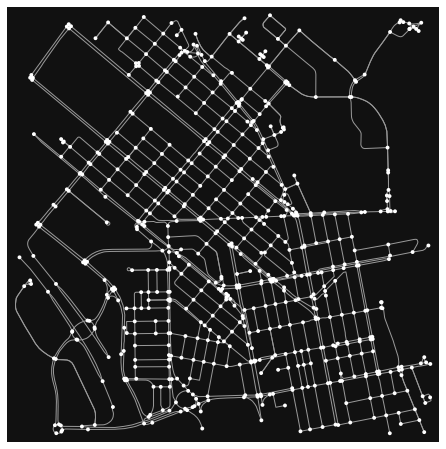

In [11]:
# obtain a graph of OSM road networks around the location

G = ox.graph_from_point(location, dist=1000, network_type='drive')  
# dist=1000 sets a radius of 1000 m from the location, can be varied
# valid inputs for network_type:
#  ‘drive’ – get drivable public streets (but not service roads)
#  ‘drive_service’ – get drivable public streets, including service roads
#  ‘walk’ – get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
#  ‘bike’ – get all streets and paths that cyclists can use
#  ‘all’ – download all (non-private) OSM streets and paths
#  ‘all_private’ – download all OSM streets and paths, including private-access ones
#  (from https://geoffboeing.com/2016/11/osmnx-python-street-networks/)

# plot the graph
fig, ax = ox.plot_graph(G, figsize=(8,8))

In [12]:
# convert the graph to an undirected graph to eliminate overlapping geometries
G2 = ox.get_undirected(G)

In [13]:
# compare the number of edges between the directed (G) and the undirected graph (G2)
m = ox.basic_stats(G)['m']
m2 = ox.basic_stats(G2)['m']
print(f'Number of edges in initial directed graph (G): {m}')
print(f'Number of edges in converted undirected graph (G2): {m2}')

Number of edges in initial directed graph (G): 1118
Number of edges in converted undirected graph (G2): 1041


In [14]:
# convert the undirected graph to a GeoDataFrame, which will be used for further operations later
df_G = ox.graph_to_gdfs(G2)
df_lines = df_G[1].copy()

# project the street network
df_lines_proj = ox.project_gdf(df_lines).reset_index().reset_index()

df_lines_proj.head()

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,highway,maxspeed,length,geometry,from,to,junction,tunnel,area
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,trunk,70,433.182,"LINESTRING (207341.119 2471812.507, 207456.976...",274243013,274243016,NaN,NaN,NaN
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,trunk_link,NaN,454.064,"LINESTRING (207004.998 2472117.096, 207040.433...",5049131572,274243013,NaN,NaN,NaN
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,trunk,70,264.169,"LINESTRING (207677.259 2471539.391, 207684.433...",274243016,6984393965,NaN,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",trunk_link,NaN,235.161,"LINESTRING (207677.259 2471539.391, 207718.666...",274243016,4773779436,NaN,NaN,NaN
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,residential,NaN,61.557,"LINESTRING (207319.719 2471846.669, 207337.506...",275909450,991295018,NaN,NaN,NaN


In [15]:
df_lines_proj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   index     1041 non-null   int64   
 1   u         1041 non-null   int64   
 2   v         1041 non-null   int64   
 3   key       1041 non-null   int64   
 4   osmid     1041 non-null   object  
 5   bridge    12 non-null     object  
 6   oneway    1041 non-null   bool    
 7   lanes     904 non-null    object  
 8   ref       4 non-null      object  
 9   name      1009 non-null   object  
 10  highway   1041 non-null   object  
 11  maxspeed  25 non-null     object  
 12  length    1041 non-null   float64 
 13  geometry  1041 non-null   geometry
 14  from      1041 non-null   int64   
 15  to        1041 non-null   int64   
 16  junction  56 non-null     object  
 17  tunnel    2 non-null      object  
 18  area      9 non-null      object  
dtypes: bool(1), float64(1), geometry(1), int

<AxesSubplot:>

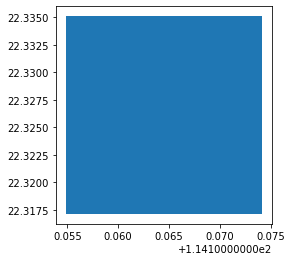

In [16]:
# create a bounding box from the extent of the graph
# later we will use this bounding box to extract or clip other data

minx, miny, maxx, maxy = df_lines.geometry.total_bounds
from shapely.geometry import Polygon
coordinates = [(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)]
polygon = Polygon(coordinates)
bbox = gp.GeoDataFrame()
bbox.loc[0,'name'] = 'bbox'
bbox.loc[0, 'geometry'] = polygon
bbox.crs = df_lines.crs
bbox.plot()

In [17]:
# helper functions to download images

import os
import time
import urllib.error
import urllib.request

def download_file(url, dst_path):
    try:
        with urllib.request.urlopen(url) as web_file:
            data = web_file.read()
            with open(dst_path, mode='wb') as local_file:
                local_file.write(data)
    except urllib.error.URLError as e:
        print(e)
        
def download_file_to_dir(url, dst_dir):
    download_file(url, os.path.join(dst_dir, os.path.basename(url)))


In [18]:
# specify download folder
# e.g. main_folder = '01_kowloon'
main_folder = '01_kowloon'
images_sample_folder = os.path.join(main_folder, 'images_sample') # sampled images will be used for blurriness detection
metadata_filename = os.path.join(main_folder, 'metadata.geojson')

In [66]:
## SKIP THIS CELL IF YOU ARE USING THE SAMPLE DATASET ##
# download metadata and images from Mapillary
# references: 
# 1. https://blog.mapillary.com/update/2020/02/06/mapillary-data-in-jupyter.html
# 2. https://from-locals.com/python-download-web-images/

#sleep_time_sec = 0.1 # create a wait time (in seconds) for each image, to prevent overloading the server

# get study area extent - we are only getting images that are within the place extent
bbox_west = minx
bbox_south = miny
bbox_east = maxx
bbox_north = maxy

print('Study area extent (west, south, east, north):')
print(bbox_west, bbox_south, bbox_east, bbox_north)

# set up key values for the API call
access_token = 'MLY|6103316279742869|bf386aec4e6014cba11cc5b83e119777' # access token can be obtained for free from Mapillary 
fields = 'id,sequence,geometry,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url' # fields we want to extract
ls_fields = fields.split(',')

# Maillary bounding box (bbox) query can only return a maximum of 2000 results for each query
# we can use a moving window of 50 x 50 m to ensure not more than 2000 results per query
# Mapillary bbox query only takes in coordinates in degrees (WGS84)

incr = 0.0004545 # 50 m is approximately 0.0004545 degrees

# construct rows from south to north
ls_rows = np.arange(bbox_south, bbox_north, incr).tolist()
ls_rows.append(bbox_north)

# construct cols from west to east
if bbox_west > 0 and bbox_east < 0: # if it crosses the 180th meridian
    ls_cols = np.arange(bbox_west, 180, incr).tolist() + np.arange(-180, bbox_east, incr).tolist()
else:
    ls_cols = np.arange(bbox_west, bbox_east, incr).tolist()
ls_cols.append(bbox_east)

print(f'Size of grid (nrow x ncol): {len(ls_rows)} x {len(ls_cols)}')
print('Download in progress...')

# create an empty GeoJSON to collect all images we find
output = {"type":"FeatureCollection","features":[]}

with open(metadata_filename, 'w') as outfile: #set output filename

    for i in range(len(ls_rows)-1): # moving down each row
    
        for j in range(len(ls_cols)-1): # moving across each column
        
            west = ls_cols[j] # west bound of moving window
            south = ls_rows[i] # south bound of moving window
            east = ls_cols[j+1] # east bound of moving window
            north = ls_rows[i+1] # north bound of moving window
        
            url = f'https://graph.mapillary.com/images?bbox={west},{south},{east},{north}&fields={fields}&access_token={access_token}'

            # print the first API call, so that we can click to see what the response looks like
            if i == 0 and j == 0:
                print(f'<First response> i = {i}, j = {j}: ', url)
        
            # make a request
            # timeout=None means the request will continue until the connection is closed,
            # change it if you only want the request to wait for a maximum number of seconds
            r = requests.get(url, timeout=None)
            
            # timeout can still happen, when the API is slow and the default timeout limit is exceeded 
            # initialise a counter to record the number of timeouts when it happens, for reference purpose
            timeout_count = 0

            # if the request failed, keep trying until success (status code = 200)
            while r.status_code != 200:
                timeout_count += 1 # update the number of timeouts
                print(f'<Timeout> i = {i}, j = {j}, timeout count: {timeout_count}, url: {url}') # print timeout information
                r = requests.get(url, timeout=None) # try again

            data = r.json() # when request is succesful, get a JSON format of the response

            for image in data['data']: # iterate through all returned images
                
                # the origional response is not in GeoJSON format
                # for each image, construct a GeoJSON Feature (for GeoJSON format, refer to https://geojson.org/)
                feature = {} 
                feature['type'] = 'Feature'
                feature['geometry'] = image['geometry']
                feature['properties'] = {}
                
                # collect non-geometry properties of the image
                for field in ls_fields:
                    if field != 'geometry':
                        feature['properties'][field] = image[field]
                
                output['features'].append(feature) # append each downloaded feature to our GeoJSON FeatureCollection
                
                total_count = len(output['features']) # update total number of images collected
                
                # sample 1 from every 10 images to download
                if total_count > 0 and total_count%10 == 0:
                    image_url = feature['properties']['thumb_2048_url']
                    download_file_to_dir(image_url, images_sample_folder)
                    #time.sleep(sleep_time_sec) # create a wait time (in seconds) for each image, to prevent overloading the server
                
                # if want to download all images:
                #image_url = feature['properties']['thumb_2048_url'] # get the image url
                #download_file_to_dir(image_url, images_folder) # download the image to our local folder
                
                # for every 500 images collected:
                # print the total number of images collected
                # print the current progress (percentage of grid currently covered by the moving window)
                if total_count > 0 and total_count%500 == 0:
                    progress = round((i*len(ls_cols)+j+1)/(len(ls_cols)*len(ls_rows))*100, 2)
                    print(f'Downloaded images: {total_count}, progress: {progress}%') 

    print(f'Total features: {total_count}') # print the final total count of images after all have been collected
    
    # send collected features to the local file
    json.dump(output, outfile)

sample_count = len([name for name in os.listdir(images_sample_folder) if os.path.isfile(os.path.join(images_sample_folder, name))]) - 1
print(f'Total sample images downloaded: {sample_count}') # print the final count of sample iamges downloaded
print('DONE') # once all images are pushed to a GeoJSON and saved, we finish


Study area extent (west, south, east, north):
114.1548286 22.3171401 114.1741047 22.3350845
Size of grid (nrow x ncol): 41 x 44
Download in progress...
<First response> i = 0, j = 0:  https://graph.mapillary.com/images?bbox=114.1548286,22.3171401,114.1552831,22.3175946&fields=id,sequence,geometry,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url&access_token=MLY|6103316279742869|bf386aec4e6014cba11cc5b83e119777
Downloaded images: 500, progress: 3.05%
Downloaded images: 1000, progress: 4.71%
Downloaded images: 1500, progress: 7.54%
Downloaded images: 2000, progress: 8.87%
Downloaded images: 2500, progress: 9.59%
Downloaded images: 3000, progress: 11.42%
Downloaded images: 3500, progress: 12.42%
Downloaded images: 4000, progress: 14.14%
Downloaded images: 4500, progress: 15.74%
Downloaded images: 5000, progress: 16.91%
Downloaded images: 5500, progress: 18.4%
Downloaded images: 6000, progress: 19.96%
Downloaded images: 6500, progress: 21.4%
<Timeout> i = 9, j = 9

In [19]:
# read the geojson file we just downloaded  
df_points = gp.read_file(metadata_filename, driver='GeoJSON')
df_points.head()

,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,geometry
0,618846552847792,D8Gr8gBjMFF9Dg9TpZshzw,49.43,1491534103000,perspective,277.536505,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (114.15650 22.31737)
1,2158725647759486,aPHUgw-HBTdYEqMJ9fD8WQ,0.00,1491733814000,perspective,8.370561,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (114.15658 22.31726)
2,157322059734609,ubuSVGpvxy3cn5MxQxSiqw,197.23,1491734199000,perspective,280.765379,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (114.15656 22.31751)
3,501254607682117,nj00z-Xtf3cnWtjuMcFWIQ,0.00,1491734198000,perspective,31.418746,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (114.15659 22.31740)
4,801790654097000,EhOvlAFXdZ_6Vhua_sP_3g,198.09,1491733814000,perspective,256.417040,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (114.15655 22.31729)


In [20]:
df_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23126 entries, 0 to 23125
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              23126 non-null  object  
 1   sequence        23126 non-null  object  
 2   altitude        23126 non-null  float64 
 3   captured_at     23126 non-null  int64   
 4   camera_type     23126 non-null  object  
 5   compass_angle   23126 non-null  float64 
 6   width           23126 non-null  int64   
 7   height          23126 non-null  int64   
 8   thumb_2048_url  23126 non-null  object  
 9   geometry        23126 non-null  geometry
dtypes: float64(2), geometry(1), int64(3), object(4)
memory usage: 1.8+ MB


In [21]:
# ensure no overlapping photos: number of unique IDs should be equal to the above total number of IDs
len(df_points['id'].unique())

23126

In [22]:
# project points
df_points_proj = ox.project_gdf(df_points)

In [23]:
# create a GeoDataFrame for all the sampled images
# sampled images will be used for blurriness detection
sample_list = [name for name in os.listdir(images_sample_folder) if os.path.isfile(os.path.join(images_sample_folder, name))]
sample_df = df_points_proj.copy()
sample_df['image_filename'] = sample_df['thumb_2048_url'].apply(lambda url: os.path.basename(url))
sample_df = sample_df[sample_df['image_filename'].isin(sample_list)]
sample_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2312 entries, 9 to 23119
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              2312 non-null   object  
 1   sequence        2312 non-null   object  
 2   altitude        2312 non-null   float64 
 3   captured_at     2312 non-null   int64   
 4   camera_type     2312 non-null   object  
 5   compass_angle   2312 non-null   float64 
 6   width           2312 non-null   int64   
 7   height          2312 non-null   int64   
 8   thumb_2048_url  2312 non-null   object  
 9   geometry        2312 non-null   geometry
 10  image_filename  2312 non-null   object  
dtypes: float64(2), geometry(1), int64(3), object(5)
memory usage: 216.8+ KB


<AxesSubplot:>

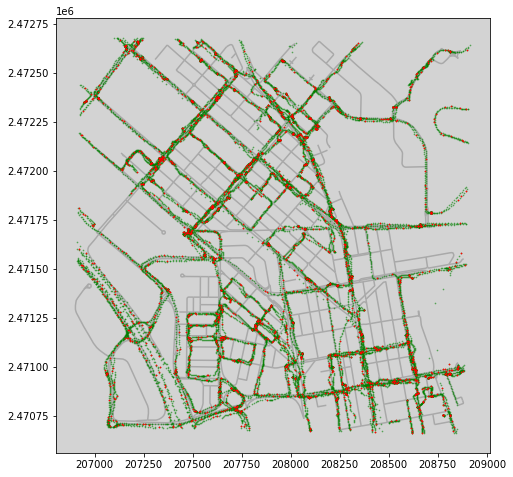

In [77]:
# Plot all the points and the locations of the sampled images
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot place area on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)

# plot points on Axis ax
df_points_proj.plot(ax=ax, marker='o', color='green', markersize=0.5, alpha=0.5, zorder=10)

# plot sampled images on Axis ax
sample_df.plot(ax=ax, marker='o', color='red', markersize=0.5, alpha=1, zorder=15)



In [27]:
# convert raster population data to vector
# raster population data is downloaded from WorldPop (https://www.worldpop.org/project/categories?id=3)
# if you intend to focus on a different area, you can download the relevant WorldPop data from the above link
# choose 'Constrained Individual countries 2020 (100m resolution)' then search for the relevant region

import rasterio
from rasterio.features import shapes

raster_dir = os.path.join(main_folder, 'hkg_ppp_2020_constrained.tif')

with rasterio.Env():
    with rasterio.open(raster_dir) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'pop_count': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=None, transform=src.transform)))
        
geoms = list(results)
df_ras = gp.GeoDataFrame.from_features(geoms)
df_pop = df_ras[df_ras['pop_count'] > 0] # only select cells with non-zero population count
df_pop.crs = df_points.crs

<AxesSubplot:>

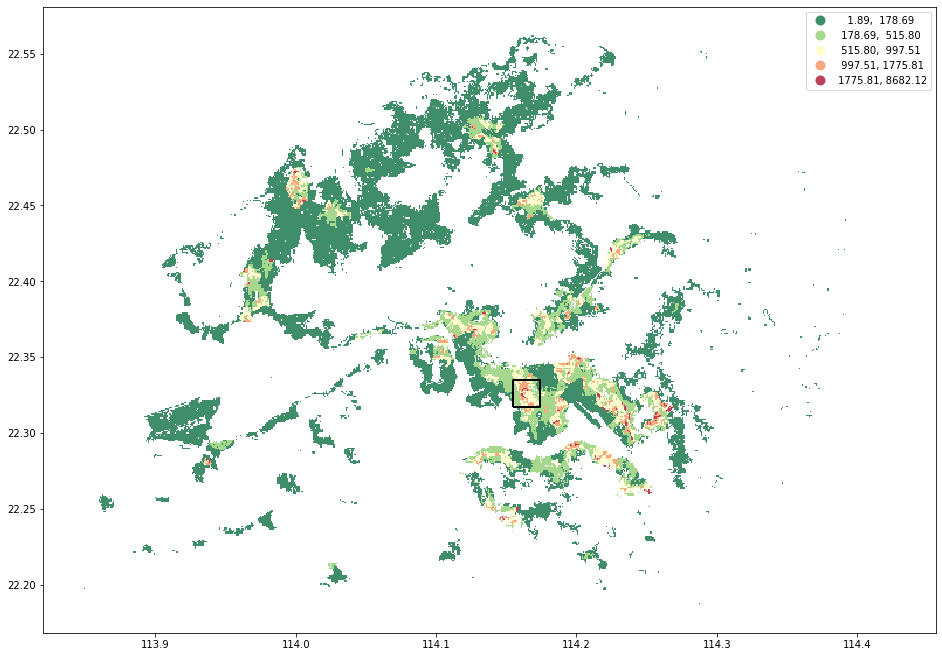

In [28]:
# visualise raster and study area bounding box
fig, ax = plt.subplots(figsize=(16,16))
df_pop.plot(ax=ax, column='pop_count', scheme='natural_breaks', k=5, cmap='RdYlGn_r', alpha=0.75, legend=True)
bbox.plot(ax=ax, fc='none', ec='black', linewidth=2)

<AxesSubplot:>

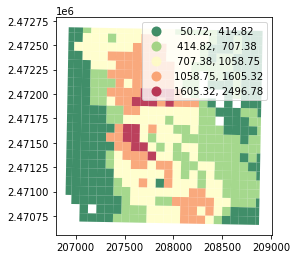

In [29]:
df_pop_clip = df_pop.clip(bbox) # clip the vectorised grid with bounding box
df_pop_proj = ox.project_gdf(df_pop_clip)
df_pop_proj.plot(column='pop_count', scheme='natural_breaks', k=5, cmap='RdYlGn_r', alpha=0.75, legend=True)

# 3. Calculate quality elements

## 3.1 Spatial coverage

- Street-based: how much of the length of each street has SVI available
- Grid-based: how many grid cells have SVI available

### Street-based

In [30]:
# function to snap photos to their nearest roads within a certain tolerance (m)
# reference: https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

def snap_photos_to_roads(points, roads, tolerance):
    """
    inputs:
        points = GeoDataFrame of points to be snapped
        roads = GeoDataFrame of lines where points are to be snapped to
        tolerance = only if a point is within this distance (meters) of a line, it will be snapped to the line
    output:
        a GeoDataFrame of snapped points
    """
    
    tolerance = 10
    
    points_bbox = points.bounds + [-tolerance, -tolerance, tolerance, tolerance] # construct bbox around each point
    
    hits = points_bbox.apply(lambda row: list(roads.sindex.intersection(row)), axis=1) # get a list of the lines that intersect with each bbox
    
    # a df that expands the hits df so there is one row for every (point index, intersecting line index) pair
    # implicitly drops those bboxes that didn’t have any lines within their window
    tmp = pd.DataFrame({
        # index of point
        "pt_idx": np.repeat(hits.index, hits.apply(len)),
        # ordinal position of line - access via iloc later
        "line_i": np.concatenate(hits.values)
    })
    
    # join tmp with roads on line_i, use reset_index() to give us the ordinal position of each line
    # rename width as road_width
    roads_2 = roads.rename(columns={"width": "road_width"})
    tmp = tmp.join(roads_2.reset_index(drop=True), on="line_i")
    
    # join with the original points, rename the point geometry as "point"
    points_2 = points.rename(columns={"geometry": "og_point"})
    tmp = tmp.join(points_2.reset_index(drop=True), on="pt_idx")
    
    # convert back to a GeoDataFrame, so we can do spatial ops
    tmp = gp.GeoDataFrame(tmp, geometry="geometry", crs=points_2.crs)
    
    # calculate the distance between each point and each of its associated lines to find the closest one
    tmp["snap_dist"] = tmp.geometry.distance(gp.GeoSeries(tmp['og_point']))
    
    # discard any lines whose distnaces from points are > tolerance
    tmp = tmp.loc[tmp.snap_dist <= tolerance]
    
    # sort on ascending snap distance, so that closest goes to top
    tmp = tmp.sort_values(by=["snap_dist"])
    
    # group by the index of the points and take the first, which is the closest line 
    closest = tmp.groupby("pt_idx").first()
    
    # construct a GeoDataFrame of the closest lines
    closest = gp.GeoDataFrame(closest, geometry="geometry", crs=points_2.crs)
    
    # position of nearest point from start of the line
    pos = closest.geometry.project(gp.GeoSeries(closest['og_point']))
    
    # get new point geometry
    snapped_pts = closest.geometry.interpolate(pos)
    
    # rename closest's geometry column
    closest_2 = closest.rename(columns={"geometry": "line_geometry"})

    # create a new GeoDataFrame from closest_2 and the new point geometries (which will be called "geometry")
    snapped = gp.GeoDataFrame(closest_2,geometry=snapped_pts).reset_index()
    
    return snapped
    
    
    


In [31]:
# snap images to their nearest roads within a buffer of 10 m 
snapped = snap_photos_to_roads(df_points_proj, df_lines_proj, 10)
snapped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18659 entries, 0 to 18658
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   pt_idx          18659 non-null  int64   
 1   line_i          18659 non-null  float64 
 2   index           18659 non-null  int64   
 3   u               18659 non-null  int64   
 4   v               18659 non-null  int64   
 5   key             18659 non-null  int64   
 6   osmid           18659 non-null  object  
 7   bridge          1082 non-null   object  
 8   oneway          18659 non-null  bool    
 9   lanes           18083 non-null  object  
 10  ref             232 non-null    object  
 11  name            18594 non-null  object  
 12  highway         18659 non-null  object  
 13  maxspeed        962 non-null    object  
 14  length          18659 non-null  float64 
 15  line_geometry   18659 non-null  geometry
 16  from            18659 non-null  int64   
 17  to  

In [32]:
snapped.head()

,pt_idx,line_i,index,u,v,key,osmid,bridge,oneway,lanes,...,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,og_point,snap_dist,geometry
0,0,61.0,61,288995381,288995461,0,26379743,None,True,2,...,49.43,1491534103000,perspective,277.536505,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207062.611 2470717.750),8.446427,POINT (207071.054 2470717.513)
1,1,61.0,61,288995381,288995461,0,26379743,None,True,2,...,0.00,1491733814000,perspective,8.370561,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207071.150 2470705.819),1.212632,POINT (207072.297 2470706.214)
2,2,61.0,61,288995381,288995461,0,26379743,None,True,2,...,197.23,1491734199000,perspective,280.765379,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207069.430 2470733.776),9.076801,POINT (207076.066 2470727.583)
3,3,61.0,61,288995381,288995461,0,26379743,None,True,2,...,0.00,1491734198000,perspective,31.418746,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207072.000 2470721.549),0.417685,POINT (207072.386 2470721.390)
4,4,61.0,61,288995381,288995461,0,26379743,None,True,2,...,198.09,1491733814000,perspective,256.417040,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207068.410 2470709.485),2.610493,POINT (207070.879 2470710.334)


In [33]:
# calculate coverage

def calculate_coverage(row, df_snapped, tolerance, max_interval):
    """
    inputs:
        row = each row of the GeoDataFrame of roads, i.e. each road
        df_snapped = a GeoDataFrame of snapped points
        tolerance = tolerance for splitting (m), i.e. if a road is within this distance from a point, it will be split at that point
        max_interval = the maximum acceptable distance between two images for the road between them to be considered 'covered'
    output:
        a GeoDataFrame of roads with their SVI coverage calculated
    """
    
    # find snapped points on the line
    line_i = row['index']
    pts = df_snapped[df_snapped['line_i']==line_i]

    # if no snapped points are found on this line, return 0% coverage
    if pts.empty:
        coverage = None
        return coverage
    
    else:
        # create buffer around points (for split tolerance)
        pts_buffer = pts.buffer(tolerance)
        
        # union all buffers
        pts_buffer_u = pts_buffer.unary_union
        
        # get line geometry
        line = row['geometry']

        # split line at point if the point is within the split tolerance
        split_line = split(line, pts_buffer_u)
        
        # transform geometry collection to GeoDataFrame
        segments = [feature for feature in split_line.geoms]
        df_segments = gp.GeoDataFrame(geometry=segments)
        df_segments.columns = ['geometry']
        
        # calculate segment length (in Euclidean distance)
        # because the geometries are already projected, and we are calculating only proportion in the end 
        df_segments['length'] = df_segments.geometry.length  
        
        # extract only segments that are longer than tolerance*2 
        df_segments_2 = df_segments[df_segments['length'] > (tolerance*2)]
        # and shorter than max_interval (2 images are deemed to be covering the road between them only if they are not further than 50 m apart)
        df_segments_3 = df_segments_2[df_segments_2['length'] <= max_interval]
        
        # calculate coverage
        coverage = round(df_segments_3['length'].sum()/line.length*100, 2)
        
        return coverage
        
        
        

    

In [34]:
s_coverage = df_lines_proj.apply(lambda row: calculate_coverage(row, snapped, 0.000001, 50), axis=1)
s_coverage

0       100.00
1        81.89
2          NaN
3       100.00
4       100.00
         ...  
1036    100.00
1037    100.00
1038    100.00
1039       NaN
1040    100.00
Length: 1041, dtype: float64

In [35]:
df_lines_proj_cov = df_lines_proj.copy()
df_lines_proj_cov['coverage'] = s_coverage
df_lines_proj_cov

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,highway,maxspeed,length,geometry,from,to,junction,tunnel,area,coverage
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,trunk,70,433.182,"LINESTRING (207341.119 2471812.507, 207456.976...",274243013,274243016,NaN,NaN,NaN,100.00
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,trunk_link,NaN,454.064,"LINESTRING (207004.998 2472117.096, 207040.433...",5049131572,274243013,NaN,NaN,NaN,81.89
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,trunk,70,264.169,"LINESTRING (207677.259 2471539.391, 207684.433...",274243016,6984393965,NaN,NaN,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",trunk_link,NaN,235.161,"LINESTRING (207677.259 2471539.391, 207718.666...",274243016,4773779436,NaN,NaN,NaN,100.00
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,residential,NaN,61.557,"LINESTRING (207319.719 2471846.669, 207337.506...",275909450,991295018,NaN,NaN,NaN,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1036,8349163524,9197567330,0,746151942,NaN,True,2,NaN,界限街 Boundary Street,primary,NaN,10.120,"LINESTRING (208247.291 2471707.498, 208253.686...",9197567330,8349163524,intersection,NaN,NaN,100.00
1037,1037,8451657975,8451657982,0,910302816,NaN,True,1,NaN,聚魚道 Chui Yu Road,secondary_link,NaN,32.850,"LINESTRING (207489.121 2471666.851, 207491.913...",8451657975,8451657982,NaN,NaN,NaN,100.00
1038,1038,8983466243,8983466244,0,"[970658211, 970658212]",NaN,True,1,NaN,染布房街 Yim Po Fong Street,secondary,NaN,27.773,"LINESTRING (208743.561 2470964.667, 208744.666...",8983466243,8983466244,NaN,NaN,NaN,100.00
1039,1039,9199524787,9199524788,1,"[996259418, 996259414, 996259415]",NaN,True,1,NaN,大坑東道 Tai Hang Tung Road,secondary,NaN,13.599,"LINESTRING (208695.650 2471913.471, 208698.271...",9199524787,9199524788,NaN,NaN,NaN,NaN


In [36]:
# check statistics of coverage values
mincov = df_lines_proj_cov['coverage'].min()
maxcov = df_lines_proj_cov['coverage'].max()
meancov = df_lines_proj_cov['coverage'].mean()
mediancov = df_lines_proj_cov['coverage'].median()
print(f'mincov = {mincov}')
print(f'maxcov = {maxcov}')
print(f'meancov = {meancov}')
print(f'mediancov = {mediancov}')

mincov = 0.0
maxcov = 100.0
meancov = 84.815312899106
mediancov = 100.0


<AxesSubplot:>

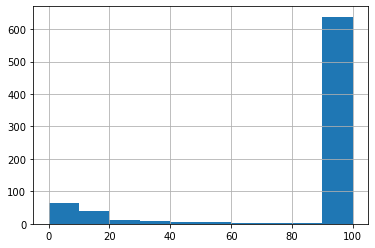

In [37]:
# check histogram of coverage values
df_lines_proj_cov['coverage'].hist()

In [38]:
def categorise_coverage(row):
    if row['coverage'] == 100:
        return '100%'
    elif row['coverage'] > 75 :
        return '>75%'
    elif row['coverage'] > 50:
        return '>50%'
    elif row['coverage'] > 25:
        return '>25%'
    elif row['coverage'] > 0:
        return '>0%'
    else:
        return '0%'


In [39]:
df_lines_proj_cov_cat = df_lines_proj_cov.copy()
df_lines_proj_cov_cat['category'] = df_lines_proj_cov_cat.apply(lambda row: categorise_coverage(row), axis=1)
df_lines_proj_cov_cat

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,maxspeed,length,geometry,from,to,junction,tunnel,area,coverage,category
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,70,433.182,"LINESTRING (207341.119 2471812.507, 207456.976...",274243013,274243016,NaN,NaN,NaN,100.00,100%
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,NaN,454.064,"LINESTRING (207004.998 2472117.096, 207040.433...",5049131572,274243013,NaN,NaN,NaN,81.89,>75%
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,70,264.169,"LINESTRING (207677.259 2471539.391, 207684.433...",274243016,6984393965,NaN,NaN,NaN,NaN,0%
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,NaN,235.161,"LINESTRING (207677.259 2471539.391, 207718.666...",274243016,4773779436,NaN,NaN,NaN,100.00,100%
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,NaN,61.557,"LINESTRING (207319.719 2471846.669, 207337.506...",275909450,991295018,NaN,NaN,NaN,100.00,100%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1036,8349163524,9197567330,0,746151942,NaN,True,2,NaN,界限街 Boundary Street,...,NaN,10.120,"LINESTRING (208247.291 2471707.498, 208253.686...",9197567330,8349163524,intersection,NaN,NaN,100.00,100%
1037,1037,8451657975,8451657982,0,910302816,NaN,True,1,NaN,聚魚道 Chui Yu Road,...,NaN,32.850,"LINESTRING (207489.121 2471666.851, 207491.913...",8451657975,8451657982,NaN,NaN,NaN,100.00,100%
1038,1038,8983466243,8983466244,0,"[970658211, 970658212]",NaN,True,1,NaN,染布房街 Yim Po Fong Street,...,NaN,27.773,"LINESTRING (208743.561 2470964.667, 208744.666...",8983466243,8983466244,NaN,NaN,NaN,100.00,100%
1039,1039,9199524787,9199524788,1,"[996259418, 996259414, 996259415]",NaN,True,1,NaN,大坑東道 Tai Hang Tung Road,...,NaN,13.599,"LINESTRING (208695.650 2471913.471, 208698.271...",9199524787,9199524788,NaN,NaN,NaN,NaN,0%


In [40]:
# check distribution of different coverage categories
df_lines_proj_cov_cat['category'].value_counts()

100%    638
0%      259
>0%     111
>25%     21
>50%      9
>75%      3
Name: category, dtype: int64

<AxesSubplot:>

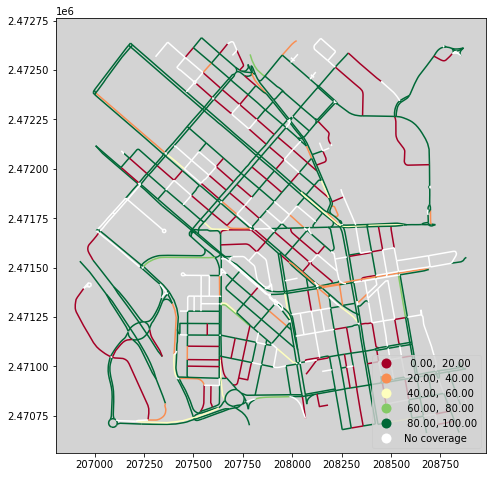

In [41]:
# visualise percentage coverage on each street

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot lines on Axis ax
df_lines_proj_cov_cat.plot(ax=ax, 
                           column='coverage', 
                           scheme='equal_interval', 
                           cmap='RdYlGn',
                           k=5,
                           legend=True,
                          missing_kwds={'color': "white",
                                       'label': "No coverage"}, 
                          legend_kwds={'facecolor':'lightgrey',
                                      'loc':'lower right'})


### Grid-based

In [42]:
# spatial join images to grid
df_cov_area = gp.sjoin(df_pop_proj, df_points_proj, how='inner')
df_cov_area

,geometry,pop_count,index_right,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21275,832911000909686,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709055000,perspective,125.532141,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21276,1387023501675073,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709054000,perspective,215.747803,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21271,477500250245603,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709054000,perspective,124.291144,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21268,4079918608717682,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709053000,perspective,214.809564,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21274,954700562026259,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709053000,perspective,122.184503,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
...,...,...,...,...,...,...,...,...,...,...,...,...
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2490,2542134822761937,DRPvcx2nTXOaH6SpkDu5fg,17.788691,1555022883284,perspective,303.633545,4032,3024,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2500,873958739857577,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730906000,perspective,337.170637,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2504,2806895052960162,wah2yyPcPpVc2qzDd7epWw,201.020000,1491730907000,perspective,235.989082,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2489,481769793042028,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730907000,perspective,337.519277,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...


In [43]:
# reset index so that the grid cell index becomes a column
df_cov_area_idx = df_cov_area.reset_index()
df_cov_area_idx

,index,geometry,pop_count,index_right,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url
0,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21275,832911000909686,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709055000,perspective,125.532141,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
1,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21276,1387023501675073,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709054000,perspective,215.747803,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
2,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21271,477500250245603,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709054000,perspective,124.291144,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
3,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21268,4079918608717682,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709053000,perspective,214.809564,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
4,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21274,954700562026259,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709053000,perspective,122.184503,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23060,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2490,2542134822761937,DRPvcx2nTXOaH6SpkDu5fg,17.788691,1555022883284,perspective,303.633545,4032,3024,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
23061,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2500,873958739857577,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730906000,perspective,337.170637,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
23062,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2504,2806895052960162,wah2yyPcPpVc2qzDd7epWw,201.020000,1491730907000,perspective,235.989082,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...
23063,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2489,481769793042028,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730907000,perspective,337.519277,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...


In [44]:
# calculate the number of images in each cell
photo_count = df_cov_area_idx.groupby("index").size()
photo_count

index
28459    103
28460    144
28461      1
28462      1
28463     38
        ... 
32072     22
32073     66
32074     22
32075     29
32076      3
Length: 380, dtype: int64

In [45]:
# rename the series
photo_count = photo_count.rename('photo_count')

In [46]:
# make a copy of the original grid dataset
df_cov_area_sum = df_pop_proj.copy()
df_cov_area_sum

,geometry,pop_count
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745
...,...,...
31895,"POLYGON ((208843.882 2470837.376, 208842.152 2...",290.855042
31896,"POLYGON ((208842.152 2470745.054, 208843.882 2...",246.724197
31702,"POLYGON ((208759.715 2470931.309, 208757.984 2...",682.900146
31704,"POLYGON ((208843.882 2470837.376, 208845.613 2...",349.960114


In [47]:
# join photo_count to grid by cell index 
df_cov_area_sum = df_cov_area_sum.join(photo_count)
df_cov_area_sum.head()

,geometry,pop_count,photo_count
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,20.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,79.0


In [48]:
df_cov_area_sum.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 514 entries, 28805 to 31703
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     514 non-null    geometry
 1   pop_count    514 non-null    float64 
 2   photo_count  380 non-null    float64 
dtypes: float64(2), geometry(1)
memory usage: 32.2 KB


<AxesSubplot:>

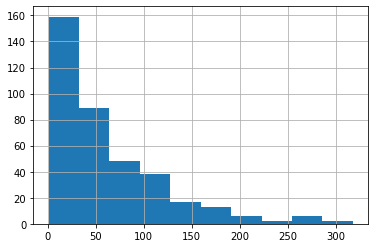

In [49]:
# check histogram of image counts
df_cov_area_sum['photo_count'].hist()

In [50]:
# spatial join road dataset to grid dataset (to find out which cells have roads)
df_grid_road = gp.sjoin(df_pop_proj, df_lines_proj, how='inner')
df_grid_road

,geometry,pop_count,index_right,index,u,v,key,osmid,bridge,oneway,...,ref,name,highway,maxspeed,length,from,to,junction,tunnel,area
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,1031,1031,7195450871,7195450872,0,"[103239104, 770879174]",NaN,True,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.842,7195450871,7195450872,NaN,NaN,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1031,1031,7195450871,7195450872,0,"[103239104, 770879174]",NaN,True,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.842,7195450871,7195450872,NaN,NaN,NaN
28978,"POLYGON ((207584.962 2472431.080, 207583.222 2...",1481.676392,1031,1031,7195450871,7195450872,0,"[103239104, 770879174]",NaN,True,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.842,7195450871,7195450872,NaN,NaN,NaN
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,439,439,660864282,7195450872,0,"[494493977, 151355564]",NaN,True,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.134,660864282,7195450872,NaN,NaN,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,439,439,660864282,7195450872,0,"[494493977, 151355564]",NaN,True,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.134,660864282,7195450872,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31896,"POLYGON ((208842.152 2470745.054, 208843.882 2...",246.724197,453,453,804108076,1636543634,0,150771615,NaN,True,...,NaN,自由道 Liberty Avenue,residential,NaN,47.565,804108076,1636543634,NaN,NaN,NaN
31704,"POLYGON ((208843.882 2470837.376, 208845.613 2...",349.960114,453,453,804108076,1636543634,0,150771615,NaN,True,...,NaN,自由道 Liberty Avenue,residential,NaN,47.565,804108076,1636543634,NaN,NaN,NaN
31896,"POLYGON ((208842.152 2470745.054, 208843.882 2...",246.724197,454,454,804108092,1636543634,0,150771615,NaN,True,...,NaN,自由道 Liberty Avenue,residential,NaN,45.770,1636543634,804108092,NaN,NaN,NaN
31702,"POLYGON ((208759.715 2470931.309, 208757.984 2...",682.900146,859,859,1636543654,1636543655,0,150771621,NaN,True,...,NaN,奶路臣街 Nelson Street,unclassified,NaN,61.704,1636543655,1636543654,NaN,NaN,NaN


In [51]:
# reset index so that the grid cell index becomes a column
df_grid_road_idx = df_grid_road.reset_index()
df_grid_road_idx

,level_0,geometry,pop_count,index_right,index,u,v,key,osmid,bridge,...,ref,name,highway,maxspeed,length,from,to,junction,tunnel,area
0,28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,1031,1031,7195450871,7195450872,0,"[103239104, 770879174]",NaN,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.842,7195450871,7195450872,NaN,NaN,NaN
1,28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1031,1031,7195450871,7195450872,0,"[103239104, 770879174]",NaN,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.842,7195450871,7195450872,NaN,NaN,NaN
2,28978,"POLYGON ((207584.962 2472431.080, 207583.222 2...",1481.676392,1031,1031,7195450871,7195450872,0,"[103239104, 770879174]",NaN,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.842,7195450871,7195450872,NaN,NaN,NaN
3,28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,439,439,660864282,7195450872,0,"[494493977, 151355564]",NaN,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.134,660864282,7195450872,NaN,NaN,NaN
4,28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,439,439,660864282,7195450872,0,"[494493977, 151355564]",NaN,...,NaN,"[九江街 Kiu Kiang Street, 福華街 Fuk Wa Street]",residential,NaN,14.134,660864282,7195450872,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,31896,"POLYGON ((208842.152 2470745.054, 208843.882 2...",246.724197,453,453,804108076,1636543634,0,150771615,NaN,...,NaN,自由道 Liberty Avenue,residential,NaN,47.565,804108076,1636543634,NaN,NaN,NaN
2170,31704,"POLYGON ((208843.882 2470837.376, 208845.613 2...",349.960114,453,453,804108076,1636543634,0,150771615,NaN,...,NaN,自由道 Liberty Avenue,residential,NaN,47.565,804108076,1636543634,NaN,NaN,NaN
2171,31896,"POLYGON ((208842.152 2470745.054, 208843.882 2...",246.724197,454,454,804108092,1636543634,0,150771615,NaN,...,NaN,自由道 Liberty Avenue,residential,NaN,45.770,1636543634,804108092,NaN,NaN,NaN
2172,31702,"POLYGON ((208759.715 2470931.309, 208757.984 2...",682.900146,859,859,1636543654,1636543655,0,150771621,NaN,...,NaN,奶路臣街 Nelson Street,unclassified,NaN,61.704,1636543655,1636543654,NaN,NaN,NaN


In [52]:
# calculate the number of roads overlapped with each cell
road_count = df_grid_road_idx.groupby("level_0").size()
road_count

level_0
28460    6
28462    2
28464    2
28465    3
28466    1
        ..
32072    1
32073    6
32074    3
32075    3
32076    1
Length: 408, dtype: int64

In [53]:
# rename the series
road_count = road_count.rename('road_count')

In [54]:
df_cov_area_sum_2 = df_cov_area_sum.copy()
df_cov_area_sum_2

,geometry,pop_count,photo_count
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,20.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,79.0
...,...,...,...
31895,"POLYGON ((208843.882 2470837.376, 208842.152 2...",290.855042,130.0
31896,"POLYGON ((208842.152 2470745.054, 208843.882 2...",246.724197,3.0
31702,"POLYGON ((208759.715 2470931.309, 208757.984 2...",682.900146,178.0
31704,"POLYGON ((208843.882 2470837.376, 208845.613 2...",349.960114,NaN


In [55]:
# join road_count to grid by cell index
df_cov_area_sum_2 = df_cov_area_sum.join(road_count)
df_cov_area_sum_2.head()

,geometry,pop_count,photo_count,road_count
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN,3.0
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,20.0,2.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0,8.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,79.0,2.0


In [56]:
df_cov_area_sum_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 514 entries, 28805 to 31703
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     514 non-null    geometry
 1   pop_count    514 non-null    float64 
 2   photo_count  380 non-null    float64 
 3   road_count   408 non-null    float64 
dtypes: float64(3), geometry(1)
memory usage: 36.2 KB


In [57]:
# function to categorise photo counts into cells with photo counts (if present), no coverage, no coverage and no roads (NaN)
def categorise_grid_photo_count(row):
    if pd.isna(row['photo_count']) and pd.notna(row['road_count']):
        return 'No coverage'
    elif pd.isna(row['photo_count']) and pd.isna(row['road_count']):
        return np.nan
    else:
        return row['photo_count']


In [58]:
# function to categorise the cell SVI coverage into: has coverage, no coverage, no coverage and no roads
def categorise_grid_photo_presence(row):
    if pd.isna(row['photo_count']) and pd.notna(row['road_count']):
        return 'No coverage'
    elif pd.isna(row['photo_count']) and pd.isna(row['road_count']):
        return 'No coverage (no roads)'
    else:
        return 'Has coverage'

In [59]:
# categorise photo counts in each cell
df_cov_area_sum_2['category'] = df_cov_area_sum_2.apply(lambda row: categorise_grid_photo_count(row), axis=1)
df_cov_area_sum_2

,geometry,pop_count,photo_count,road_count,category
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN,3.0,No coverage
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,20.0,2.0,20.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN,NaN,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0,8.0,1.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,79.0,2.0,79.0
...,...,...,...,...,...
31895,"POLYGON ((208843.882 2470837.376, 208842.152 2...",290.855042,130.0,6.0,130.0
31896,"POLYGON ((208842.152 2470745.054, 208843.882 2...",246.724197,3.0,3.0,3.0
31702,"POLYGON ((208759.715 2470931.309, 208757.984 2...",682.900146,178.0,4.0,178.0
31704,"POLYGON ((208843.882 2470837.376, 208845.613 2...",349.960114,NaN,1.0,No coverage


In [60]:
# categorise coverage type in each cell
df_cov_area_sum_2['category_2'] = df_cov_area_sum_2.apply(lambda row: categorise_grid_photo_presence(row), axis=1)
df_cov_area_sum_2

,geometry,pop_count,photo_count,road_count,category,category_2
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN,3.0,No coverage,No coverage
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,20.0,2.0,20.0,Has coverage
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN,NaN,NaN,No coverage (no roads)
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0,8.0,1.0,Has coverage
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,79.0,2.0,79.0,Has coverage
...,...,...,...,...,...,...
31895,"POLYGON ((208843.882 2470837.376, 208842.152 2...",290.855042,130.0,6.0,130.0,Has coverage
31896,"POLYGON ((208842.152 2470745.054, 208843.882 2...",246.724197,3.0,3.0,3.0,Has coverage
31702,"POLYGON ((208759.715 2470931.309, 208757.984 2...",682.900146,178.0,4.0,178.0,Has coverage
31704,"POLYGON ((208843.882 2470837.376, 208845.613 2...",349.960114,NaN,1.0,No coverage,No coverage


In [61]:
df_cov_area_sum_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 514 entries, 28805 to 31703
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     514 non-null    geometry
 1   pop_count    514 non-null    float64 
 2   photo_count  380 non-null    float64 
 3   road_count   408 non-null    float64 
 4   category     443 non-null    object  
 5   category_2   514 non-null    object  
dtypes: float64(3), geometry(1), object(2)
memory usage: 44.3+ KB


In [62]:
df_cov_area_sum_2['category'].value_counts()

No coverage    63
1.0            13
13.0           10
4.0             8
3.0             8
               ..
84.0            1
233.0           1
155.0           1
277.0           1
178.0           1
Name: category, Length: 148, dtype: int64

<AxesSubplot:>

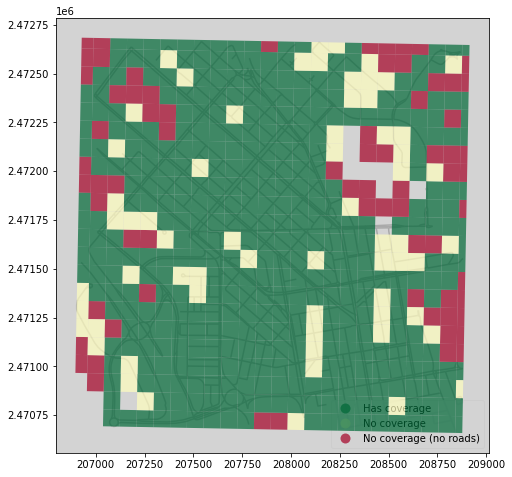

In [63]:
# visualise coverage type

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot roads on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)

# plot grids on Axis ax
df_cov_area_sum_2.plot(ax=ax, 
                     column='category_2', 
                     categorical=True, 
                     cmap='RdYlGn_r',
                     alpha=0.7,
                     legend=True, 
                     zorder=10, 
                     legend_kwds={'facecolor':'lightgrey',
                                 'loc':'lower right'})




## 3.2 Spatial continuity

- Street-based: the average spacing interval between photographed locations, calculated along each street

### Street-based

In [64]:
# calculate the total count of snapped points per road
snapped_per_line = snapped.groupby('line_i').size()
snapped_per_line

line_i
0.0       124
1.0        46
3.0        18
4.0         7
5.0        46
         ... 
1035.0      1
1036.0      2
1037.0      2
1038.0      1
1040.0      3
Length: 783, dtype: int64

In [65]:
# attach the count of snapped points to the GeoDataFrame of roads
df_lines_proj_den = df_lines_proj_cov_cat.copy()
df_lines_proj_den['photos_count'] = snapped_per_line
df_lines_proj_den.head()

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,length,geometry,from,to,junction,tunnel,area,coverage,category,photos_count
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,433.182,"LINESTRING (207341.119 2471812.507, 207456.976...",274243013,274243016,NaN,NaN,NaN,100.00,100%,124.0
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,454.064,"LINESTRING (207004.998 2472117.096, 207040.433...",5049131572,274243013,NaN,NaN,NaN,81.89,>75%,46.0
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,264.169,"LINESTRING (207677.259 2471539.391, 207684.433...",274243016,6984393965,NaN,NaN,NaN,NaN,0%,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,235.161,"LINESTRING (207677.259 2471539.391, 207718.666...",274243016,4773779436,NaN,NaN,NaN,100.00,100%,18.0
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,61.557,"LINESTRING (207319.719 2471846.669, 207337.506...",275909450,991295018,NaN,NaN,NaN,100.00,100%,7.0


In [66]:
# calculate the length of each road
df_lines_proj_den['cal_length'] = df_lines_proj_den.geometry.length
df_lines_proj_den.head()

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,geometry,from,to,junction,tunnel,area,coverage,category,photos_count,cal_length
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,"LINESTRING (207341.119 2471812.507, 207456.976...",274243013,274243016,NaN,NaN,NaN,100.00,100%,124.0,433.212488
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,"LINESTRING (207004.998 2472117.096, 207040.433...",5049131572,274243013,NaN,NaN,NaN,81.89,>75%,46.0,453.958612
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,"LINESTRING (207677.259 2471539.391, 207684.433...",274243016,6984393965,NaN,NaN,NaN,NaN,0%,NaN,264.125775
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,"LINESTRING (207677.259 2471539.391, 207718.666...",274243016,4773779436,NaN,NaN,NaN,100.00,100%,18.0,235.191714
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,"LINESTRING (207319.719 2471846.669, 207337.506...",275909450,991295018,NaN,NaN,NaN,100.00,100%,7.0,61.488773


In [67]:
# calculate the average spacing interval (m) between photos on each road
df_lines_proj_den['avg_sample_dist'] = round(df_lines_proj_den['cal_length']/df_lines_proj_den['photos_count'],2)
df_lines_proj_den.head()

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,from,to,junction,tunnel,area,coverage,category,photos_count,cal_length,avg_sample_dist
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,274243013,274243016,NaN,NaN,NaN,100.00,100%,124.0,433.212488,3.49
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,5049131572,274243013,NaN,NaN,NaN,81.89,>75%,46.0,453.958612,9.87
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,274243016,6984393965,NaN,NaN,NaN,NaN,0%,NaN,264.125775,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,274243016,4773779436,NaN,NaN,NaN,100.00,100%,18.0,235.191714,13.07
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,275909450,991295018,NaN,NaN,NaN,100.00,100%,7.0,61.488773,8.78


<AxesSubplot:>

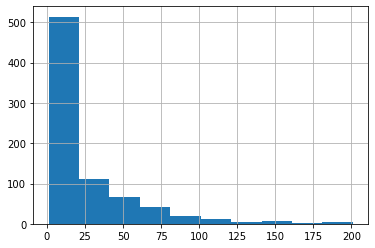

In [68]:
# check the histogram of the average spacing interval
df_lines_proj_den.photos_count.hist()

<AxesSubplot:>

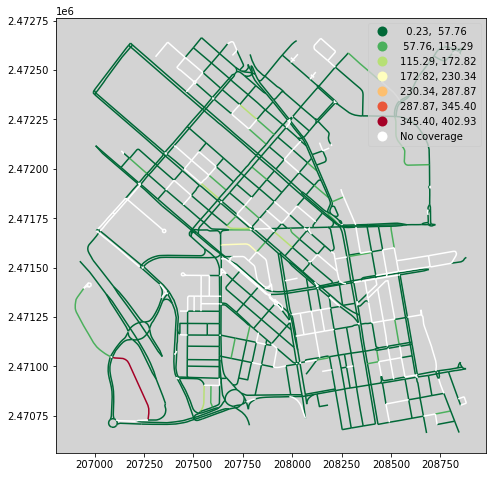

In [69]:
# visualise average spacing interval (m) between photos per road

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot lines on Axis ax
df_lines_proj_den.plot(ax=ax, 
                           column='avg_sample_dist', 
                           scheme='equal_interval', 
                           cmap='RdYlGn_r',
                           k=7,
                           legend=True,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey'})

## 3.3 Count

- Street-based: the number of images found along each street
- Grid-based: the number of images found in each grid cell

### Street-based

<AxesSubplot:>

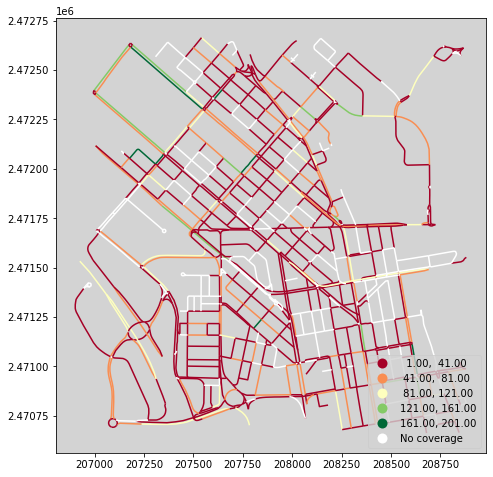

In [70]:
# visualise number of photos per road

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot lines on Axis ax
df_lines_proj_den.plot(ax=ax, 
                           column='photos_count', 
                           scheme='equal_interval', 
                           cmap='RdYlGn',
                           k=5,
                           legend=True, 
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey',
                                   'loc':'lower right'})


### Grid-based

<AxesSubplot:>

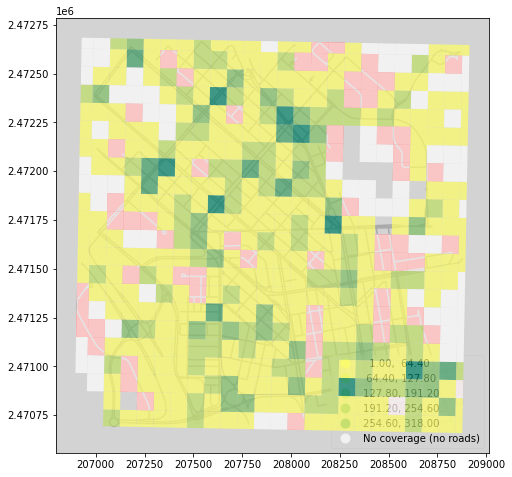

In [71]:
# visualise count

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot roads on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)


# plot grids on Axis ax
df_cov_area_sum.plot(ax=ax, 
                     column='photo_count', 
                     scheme='equal_interval', 
                     cmap='summer_r',
                     k=5,
                     alpha=0.7,
                     legend=True, 
                     zorder=10, 
                     missing_kwds={'color': "white",
                                   'label': "No coverage (no roads)"},
                     legend_kwds={'facecolor':'lightgrey',
                                 'loc':'lower right'})

df_cov_area_sum_2[df_cov_area_sum_2['category'] == 'No coverage'].plot(ax=ax, alpha=0.7, color='red')
                       


## 3.4 Age of the most recent coverage

- Street-based: the age of the most recent image found on each street
- Grid-based: the age of the most recent image found in each cell

### Street-based

In [72]:
# current time in ms
now = round(time.time(), 3)*1000
now
# now = 1651596238569.0

1651596238569.0

In [73]:
# calculate the age of each snapped image in days, months, and years
snapped_age = snapped.copy()

snapped_age['age_ms'] = now - snapped_age['captured_at']
snapped_age['age_d'] = round((now - snapped_age['captured_at']) / (1000 * 3600 * 24), 0)
# assume 30 days in a month, 365 days in a year
snapped_age['age_m'] = round((now - snapped_age['captured_at']) / (1000 * 3600 * 24 * 30), 0)
snapped_age['age_y'] = round((now - snapped_age['captured_at']) / (1000 * 3600 * 24 * 365), 0)

snapped_age.head()

,pt_idx,line_i,index,u,v,key,osmid,bridge,oneway,lanes,...,width,height,thumb_2048_url,og_point,snap_dist,geometry,age_ms,age_d,age_m,age_y
0,0,61.0,61,288995381,288995461,0,26379743,None,True,2,...,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207062.611 2470717.750),8.446427,POINT (207071.054 2470717.513),1.600621e+11,1853.0,62.0,5.0
1,1,61.0,61,288995381,288995461,0,26379743,None,True,2,...,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207071.150 2470705.819),1.212632,POINT (207072.297 2470706.214),1.598624e+11,1850.0,62.0,5.0
2,2,61.0,61,288995381,288995461,0,26379743,None,True,2,...,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207069.430 2470733.776),9.076801,POINT (207076.066 2470727.583),1.598620e+11,1850.0,62.0,5.0
3,3,61.0,61,288995381,288995461,0,26379743,None,True,2,...,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207072.000 2470721.549),0.417685,POINT (207072.386 2470721.390),1.598620e+11,1850.0,62.0,5.0
4,4,61.0,61,288995381,288995461,0,26379743,None,True,2,...,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207068.410 2470709.485),2.610493,POINT (207070.879 2470710.334),1.598624e+11,1850.0,62.0,5.0


<AxesSubplot:>

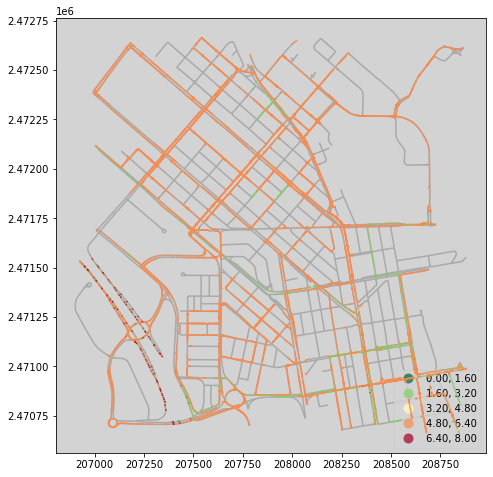

In [79]:
# visualise ages, point-based

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot place area on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)

# plot lines on Axis ax
snapped_age.plot(ax=ax, 
                           column='age_y', 
                           scheme='equal_interval', 
                           cmap='RdYlGn_r',
                           k=5, 
                 alpha=0.7, 
                 markersize=0.5,
                 zorder=10,
                           legend=True,
                 legend_kwds={'facecolor':'lightgrey',
                            'loc':'lower right'})

In [80]:
# find the minimum image age for each road (most recent coverage)
age_by_rd = snapped_age.groupby('line_i')['age_y'].min()
age_by_rd

line_i
0.0       2.0
1.0       2.0
3.0       2.0
4.0       5.0
5.0       5.0
         ... 
1035.0    5.0
1036.0    5.0
1037.0    5.0
1038.0    5.0
1040.0    5.0
Name: age_y, Length: 783, dtype: float64

In [81]:
# attach the series of most recent coverage ages to the GeoDataFrame of roads
df_lines_age = df_lines_proj_den.copy()
df_lines_age['age_newest'] = age_by_rd
df_lines_age

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,to,junction,tunnel,area,coverage,category,photos_count,cal_length,avg_sample_dist,age_newest
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,274243016,NaN,NaN,NaN,100.00,100%,124.0,433.212488,3.49,2.0
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,274243013,NaN,NaN,NaN,81.89,>75%,46.0,453.958612,9.87,2.0
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,6984393965,NaN,NaN,NaN,NaN,0%,NaN,264.125775,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,4773779436,NaN,NaN,NaN,100.00,100%,18.0,235.191714,13.07,2.0
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,991295018,NaN,NaN,NaN,100.00,100%,7.0,61.488773,8.78,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1036,8349163524,9197567330,0,746151942,NaN,True,2,NaN,界限街 Boundary Street,...,8349163524,intersection,NaN,NaN,100.00,100%,2.0,10.106919,5.05,5.0
1037,1037,8451657975,8451657982,0,910302816,NaN,True,1,NaN,聚魚道 Chui Yu Road,...,8451657982,NaN,NaN,NaN,100.00,100%,2.0,32.861436,16.43,5.0
1038,1038,8983466243,8983466244,0,"[970658211, 970658212]",NaN,True,1,NaN,染布房街 Yim Po Fong Street,...,8983466244,NaN,NaN,NaN,100.00,100%,1.0,27.685424,27.69,5.0
1039,1039,9199524787,9199524788,1,"[996259418, 996259414, 996259415]",NaN,True,1,NaN,大坑東道 Tai Hang Tung Road,...,9199524788,NaN,NaN,NaN,NaN,0%,NaN,13.574146,NaN,NaN


<AxesSubplot:>

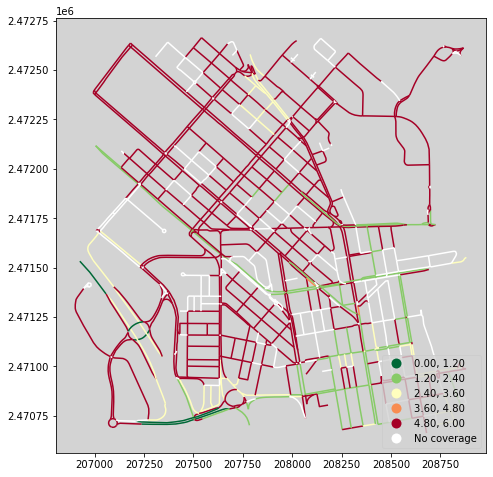

In [82]:
# visualise age of newest coverage (in years) found on each road

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot lines on Axis ax
df_lines_age.plot(ax=ax, 
                           column='age_newest', 
                           scheme='equal_interval', 
                           cmap='RdYlGn_r',
                           k=5,
                           legend=True,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey',
                                   'loc':'lower right'})

### Grid-based

In [86]:
# calculate the age of each image (original, unsnapped point)
df_points_age = df_points_proj.copy()
df_points_age['age_ms'] = now - df_points_age['captured_at']
df_points_age['age_d'] = round((now - df_points_age['captured_at']) / (1000 * 3600 * 24), 0)
# assume 30 days in a month, 365 days in a year
df_points_age['age_m'] = round((now - df_points_age['captured_at']) / (1000 * 3600 * 24 * 30), 0)
df_points_age['age_y'] = round((now - df_points_age['captured_at']) / (1000 * 3600 * 24 * 365), 0)
df_points_age.head()

,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,geometry,age_ms,age_d,age_m,age_y
0,618846552847792,D8Gr8gBjMFF9Dg9TpZshzw,49.43,1491534103000,perspective,277.536505,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207062.611 2470717.750),1.600621e+11,1853.0,62.0,5.0
1,2158725647759486,aPHUgw-HBTdYEqMJ9fD8WQ,0.00,1491733814000,perspective,8.370561,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207071.150 2470705.819),1.598624e+11,1850.0,62.0,5.0
2,157322059734609,ubuSVGpvxy3cn5MxQxSiqw,197.23,1491734199000,perspective,280.765379,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207069.430 2470733.776),1.598620e+11,1850.0,62.0,5.0
3,501254607682117,nj00z-Xtf3cnWtjuMcFWIQ,0.00,1491734198000,perspective,31.418746,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207072.000 2470721.549),1.598620e+11,1850.0,62.0,5.0
4,801790654097000,EhOvlAFXdZ_6Vhua_sP_3g,198.09,1491733814000,perspective,256.417040,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207068.410 2470709.485),1.598624e+11,1850.0,62.0,5.0


In [87]:
# spatial join images to grid
df_grid_age = gp.sjoin(df_pop_proj, df_points_age, how='inner')
df_grid_age

,geometry,pop_count,index_right,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,age_ms,age_d,age_m,age_y
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21275,832911000909686,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709055000,perspective,125.532141,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21276,1387023501675073,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709054000,perspective,215.747803,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21271,477500250245603,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709054000,perspective,124.291144,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21268,4079918608717682,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709053000,perspective,214.809564,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21274,954700562026259,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709053000,perspective,122.184503,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2490,2542134822761937,DRPvcx2nTXOaH6SpkDu5fg,17.788691,1555022883284,perspective,303.633545,4032,3024,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,9.657336e+10,1118.0,37.0,3.0
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2500,873958739857577,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730906000,perspective,337.170637,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2504,2806895052960162,wah2yyPcPpVc2qzDd7epWw,201.020000,1491730907000,perspective,235.989082,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2489,481769793042028,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730907000,perspective,337.519277,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0


In [88]:
# reset index so that the grid cell index becomes a column
df_grid_age_idx = df_grid_age.reset_index()
df_grid_age_idx

,index,geometry,pop_count,index_right,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,age_ms,age_d,age_m,age_y
0,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21275,832911000909686,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709055000,perspective,125.532141,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
1,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21276,1387023501675073,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709054000,perspective,215.747803,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
2,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21271,477500250245603,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709054000,perspective,124.291144,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
3,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21268,4079918608717682,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709053000,perspective,214.809564,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
4,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21274,954700562026259,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709053000,perspective,122.184503,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23060,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2490,2542134822761937,DRPvcx2nTXOaH6SpkDu5fg,17.788691,1555022883284,perspective,303.633545,4032,3024,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,9.657336e+10,1118.0,37.0,3.0
23061,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2500,873958739857577,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730906000,perspective,337.170637,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0
23062,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2504,2806895052960162,wah2yyPcPpVc2qzDd7epWw,201.020000,1491730907000,perspective,235.989082,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0
23063,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2489,481769793042028,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730907000,perspective,337.519277,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0


In [89]:
# find the minimum age of coverage (most recent coverage) in each grid cell
newest_age_grid = df_grid_age_idx.groupby("index")['age_y'].min()
newest_age_grid

index
28459    1.0
28460    5.0
28461    5.0
28462    5.0
28463    5.0
        ... 
32072    2.0
32073    5.0
32074    5.0
32075    3.0
32076    3.0
Name: age_y, Length: 380, dtype: float64

In [90]:
# rename the series
newest_age_grid = newest_age_grid.rename('age_newest')

In [91]:
# join age_newest to grid by cell index
df_grid_newst = df_pop_proj.copy()
df_grid_newst = df_grid_newst.join(newest_age_grid)
df_grid_newst.head()

,geometry,pop_count,age_newest
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,5.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,5.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,5.0


In [92]:
df_grid_newst.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 514 entries, 28805 to 31703
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    514 non-null    geometry
 1   pop_count   514 non-null    float64 
 2   age_newest  380 non-null    float64 
dtypes: float64(2), geometry(1)
memory usage: 32.2 KB


<AxesSubplot:>

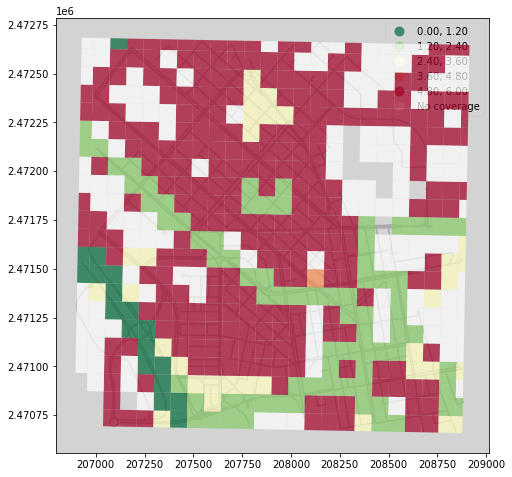

In [93]:
# visualise the age of most recent coverage in each grid cell

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot roads on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)


# plot grids on Axis ax
df_grid_newst.plot(ax=ax, 
                     column='age_newest', 
                     scheme='equal_interval', 
                     cmap='RdYlGn_r',
                     k=5,
                     alpha=0.7,
                     legend=True, 
                     zorder=10, 
                     missing_kwds={'color': "white",
                                   'label': "No coverage"},
                     legend_kwds={'facecolor':'lightgrey'})





## 3.5 Age of the first available photos

- Street-based: the age of the first available image found on each street
- Grid-based: the age of the first available image found in each cell

### Street-based

In [94]:
# find the maximum image age (the first available coverage) for each road
age_by_rd_oldest = snapped_age.groupby('line_i')['age_y'].max()
age_by_rd_oldest

line_i
0.0       5.0
1.0       5.0
3.0       2.0
4.0       5.0
5.0       5.0
         ... 
1035.0    5.0
1036.0    5.0
1037.0    5.0
1038.0    5.0
1040.0    5.0
Name: age_y, Length: 783, dtype: float64

In [95]:
# attach the series of first available coverage ages to the GeoDataFrame of roads
df_lines_age_oldest = df_lines_age.copy()
df_lines_age_oldest['age_oldest'] = age_by_rd_oldest
df_lines_age_oldest

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,junction,tunnel,area,coverage,category,photos_count,cal_length,avg_sample_dist,age_newest,age_oldest
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,NaN,NaN,NaN,100.00,100%,124.0,433.212488,3.49,2.0,5.0
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,NaN,NaN,NaN,81.89,>75%,46.0,453.958612,9.87,2.0,5.0
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,NaN,NaN,NaN,NaN,0%,NaN,264.125775,NaN,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,NaN,NaN,NaN,100.00,100%,18.0,235.191714,13.07,2.0,2.0
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,NaN,NaN,NaN,100.00,100%,7.0,61.488773,8.78,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1036,8349163524,9197567330,0,746151942,NaN,True,2,NaN,界限街 Boundary Street,...,intersection,NaN,NaN,100.00,100%,2.0,10.106919,5.05,5.0,5.0
1037,1037,8451657975,8451657982,0,910302816,NaN,True,1,NaN,聚魚道 Chui Yu Road,...,NaN,NaN,NaN,100.00,100%,2.0,32.861436,16.43,5.0,5.0
1038,1038,8983466243,8983466244,0,"[970658211, 970658212]",NaN,True,1,NaN,染布房街 Yim Po Fong Street,...,NaN,NaN,NaN,100.00,100%,1.0,27.685424,27.69,5.0,5.0
1039,1039,9199524787,9199524788,1,"[996259418, 996259414, 996259415]",NaN,True,1,NaN,大坑東道 Tai Hang Tung Road,...,NaN,NaN,NaN,NaN,0%,NaN,13.574146,NaN,NaN,NaN


<AxesSubplot:>

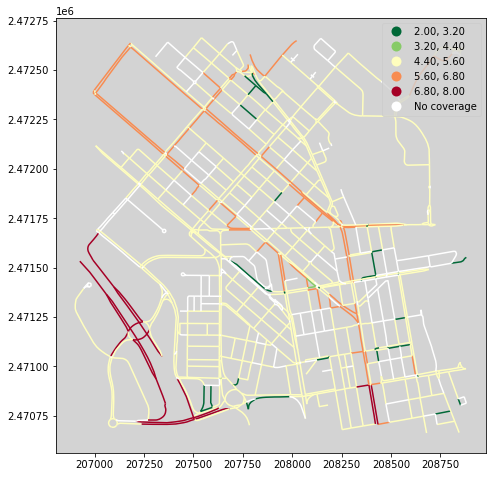

In [96]:
# visualise the age of the first available coverage on each road

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot lines on Axis ax
df_lines_age_oldest.plot(ax=ax, 
                           column='age_oldest', 
                           scheme='equal_interval', 
                           cmap='RdYlGn_r',
                           k=5,
                           legend=True,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey'})

### Grid-based

In [97]:
# find the age of the first available coverage in each cell
oldest_age_grid = df_grid_age_idx.groupby("index")['age_y'].max()
oldest_age_grid

index
28459    6.0
28460    6.0
28461    5.0
28462    5.0
28463    5.0
        ... 
32072    2.0
32073    5.0
32074    5.0
32075    5.0
32076    5.0
Name: age_y, Length: 380, dtype: float64

In [98]:
# rename the series
oldest_age_grid = oldest_age_grid.rename('age_oldest')

In [99]:
# join age_oldest to grid by cell index
df_grid_oldest = df_pop_proj.copy()
df_grid_oldest = df_grid_oldest.join(oldest_age_grid)
df_grid_oldest.head()

,geometry,pop_count,age_oldest
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,6.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,5.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,6.0


In [100]:
df_grid_oldest.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 514 entries, 28805 to 31703
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    514 non-null    geometry
 1   pop_count   514 non-null    float64 
 2   age_oldest  380 non-null    float64 
dtypes: float64(2), geometry(1)
memory usage: 32.2 KB


<AxesSubplot:>

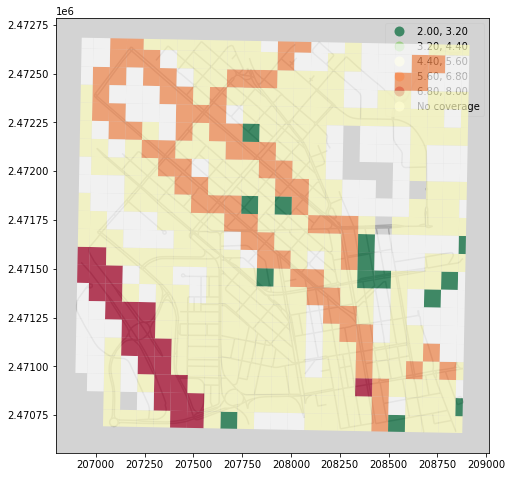

In [101]:
# visualise the age of first available coverage in each grid cell

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot roads on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)


# plot grids on Axis ax
df_grid_oldest.plot(ax=ax, 
                     column='age_oldest', 
                     scheme='equal_interval', 
                     cmap='RdYlGn_r',
                     k=5,
                     alpha=0.7,
                     legend=True, 
                     zorder=10, 
                     missing_kwds={'color': "white",
                                   'label': "No coverage"},
                     legend_kwds={'facecolor':'lightgrey'})





## 3.6 Number of years covered

- Street-based: the number of years in which the street has SVI available
- Grid-based: the number of years in which the cell has SVI available

### Street-based

In [102]:
# calculate the year and month each image (snapped) was taken in
# if you are running this notebook in a different timezone than UTC+08:00, please convert the result (which is in your local timezone) to UTC+08:00
snapped_dt = snapped_age.copy()

snapped_dt['datetime'] = snapped_dt['captured_at'].apply(
    lambda x: datetime.datetime.fromtimestamp(
        round(int(x)/1000, 0)
    ).strftime('%Y-%m-%d %H:%M:%S'))

snapped_dt['year'] = snapped_dt['captured_at'].apply(
    lambda x: datetime.datetime.fromtimestamp(
        round(int(x)/1000, 0)
    ).year)

snapped_dt['month'] = snapped_dt['captured_at'].apply(
    lambda x: datetime.datetime.fromtimestamp(
        round(int(x)/1000, 0)
    ).month)

snapped_dt['month'] = snapped_dt['captured_at'].apply(
    lambda x: datetime.datetime.fromtimestamp(
        round(int(x)/1000, 0)
    ).month)

snapped_dt.head()

,pt_idx,line_i,index,u,v,key,osmid,bridge,oneway,lanes,...,og_point,snap_dist,geometry,age_ms,age_d,age_m,age_y,datetime,year,month
0,0,61.0,61,288995381,288995461,0,26379743,None,True,2,...,POINT (207062.611 2470717.750),8.446427,POINT (207071.054 2470717.513),1.600621e+11,1853.0,62.0,5.0,2017-04-07 11:01:43,2017,4
1,1,61.0,61,288995381,288995461,0,26379743,None,True,2,...,POINT (207071.150 2470705.819),1.212632,POINT (207072.297 2470706.214),1.598624e+11,1850.0,62.0,5.0,2017-04-09 18:30:14,2017,4
2,2,61.0,61,288995381,288995461,0,26379743,None,True,2,...,POINT (207069.430 2470733.776),9.076801,POINT (207076.066 2470727.583),1.598620e+11,1850.0,62.0,5.0,2017-04-09 18:36:39,2017,4
3,3,61.0,61,288995381,288995461,0,26379743,None,True,2,...,POINT (207072.000 2470721.549),0.417685,POINT (207072.386 2470721.390),1.598620e+11,1850.0,62.0,5.0,2017-04-09 18:36:38,2017,4
4,4,61.0,61,288995381,288995461,0,26379743,None,True,2,...,POINT (207068.410 2470709.485),2.610493,POINT (207070.879 2470710.334),1.598624e+11,1850.0,62.0,5.0,2017-04-09 18:30:14,2017,4


In [103]:
snapped_dt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18659 entries, 0 to 18658
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   pt_idx          18659 non-null  int64   
 1   line_i          18659 non-null  float64 
 2   index           18659 non-null  int64   
 3   u               18659 non-null  int64   
 4   v               18659 non-null  int64   
 5   key             18659 non-null  int64   
 6   osmid           18659 non-null  object  
 7   bridge          1082 non-null   object  
 8   oneway          18659 non-null  bool    
 9   lanes           18083 non-null  object  
 10  ref             232 non-null    object  
 11  name            18594 non-null  object  
 12  highway         18659 non-null  object  
 13  maxspeed        962 non-null    object  
 14  length          18659 non-null  float64 
 15  line_geometry   18659 non-null  geometry
 16  from            18659 non-null  int64   
 17  to  

In [104]:
# calculate the numbers of unique years and months in which the road has been covered
nyears_by_rd = snapped_dt.groupby('line_i')['year'].nunique()
nmonths_by_rd = snapped_dt.groupby('line_i')['month'].nunique()

In [105]:
# attach nyears and nmonths to the GeoDataFrame of roads
df_lines_nym = df_lines_age_oldest.copy()
df_lines_nym['nyears'] = nyears_by_rd
df_lines_nym['nmonths'] = nmonths_by_rd
df_lines_nym

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,area,coverage,category,photos_count,cal_length,avg_sample_dist,age_newest,age_oldest,nyears,nmonths
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,NaN,100.00,100%,124.0,433.212488,3.49,2.0,5.0,2.0,2.0
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,NaN,81.89,>75%,46.0,453.958612,9.87,2.0,5.0,2.0,2.0
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,NaN,NaN,0%,NaN,264.125775,NaN,NaN,NaN,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,NaN,100.00,100%,18.0,235.191714,13.07,2.0,2.0,1.0,1.0
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,NaN,100.00,100%,7.0,61.488773,8.78,5.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1036,8349163524,9197567330,0,746151942,NaN,True,2,NaN,界限街 Boundary Street,...,NaN,100.00,100%,2.0,10.106919,5.05,5.0,5.0,1.0,1.0
1037,1037,8451657975,8451657982,0,910302816,NaN,True,1,NaN,聚魚道 Chui Yu Road,...,NaN,100.00,100%,2.0,32.861436,16.43,5.0,5.0,1.0,1.0
1038,1038,8983466243,8983466244,0,"[970658211, 970658212]",NaN,True,1,NaN,染布房街 Yim Po Fong Street,...,NaN,100.00,100%,1.0,27.685424,27.69,5.0,5.0,1.0,1.0
1039,1039,9199524787,9199524788,1,"[996259418, 996259414, 996259415]",NaN,True,1,NaN,大坑東道 Tai Hang Tung Road,...,NaN,NaN,0%,NaN,13.574146,NaN,NaN,NaN,NaN,NaN


In [106]:
df_lines_nym['nyears'].value_counts()

1.0    587
2.0    148
3.0     32
4.0     11
5.0      5
Name: nyears, dtype: int64

In [107]:
df_lines_nym['nmonths'].value_counts()

1.0    590
2.0    142
3.0     30
4.0     12
5.0      6
6.0      2
7.0      1
Name: nmonths, dtype: int64

<AxesSubplot:>

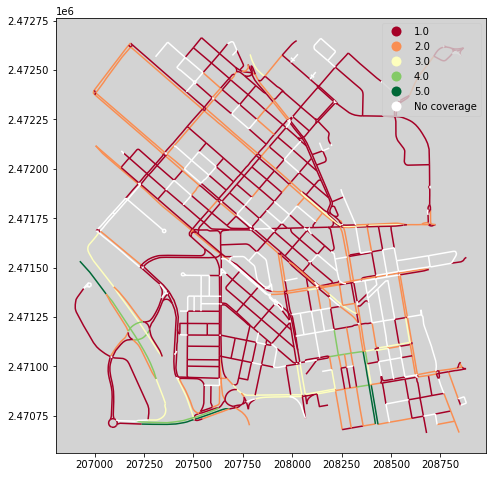

In [108]:
# visualise the number of years in which each road is covered

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot lines on Axis ax
df_lines_nym.plot(ax=ax, 
                           column='nyears', 
                           categorical=True, 
                           cmap='RdYlGn',
                           legend=True,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey'})



### Grid-based

In [109]:
# calculate the year and month each image (original, unsnapped) was taken in

df_points_dt = df_points_age.copy()

df_points_dt['datetime'] = df_points_dt['captured_at'].apply(
    lambda x: datetime.datetime.fromtimestamp(
        round(int(x)/1000, 0)
    ).strftime('%Y-%m-%d %H:%M:%S'))

df_points_dt['year'] = df_points_dt['captured_at'].apply(
    lambda x: datetime.datetime.fromtimestamp(
        round(int(x)/1000, 0)
    ).year)

df_points_dt['month'] = df_points_dt['captured_at'].apply(
    lambda x: datetime.datetime.fromtimestamp(
        round(int(x)/1000, 0)
    ).month)

df_points_dt.head()

,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,geometry,age_ms,age_d,age_m,age_y,datetime,year,month
0,618846552847792,D8Gr8gBjMFF9Dg9TpZshzw,49.43,1491534103000,perspective,277.536505,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207062.611 2470717.750),1.600621e+11,1853.0,62.0,5.0,2017-04-07 11:01:43,2017,4
1,2158725647759486,aPHUgw-HBTdYEqMJ9fD8WQ,0.00,1491733814000,perspective,8.370561,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207071.150 2470705.819),1.598624e+11,1850.0,62.0,5.0,2017-04-09 18:30:14,2017,4
2,157322059734609,ubuSVGpvxy3cn5MxQxSiqw,197.23,1491734199000,perspective,280.765379,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207069.430 2470733.776),1.598620e+11,1850.0,62.0,5.0,2017-04-09 18:36:39,2017,4
3,501254607682117,nj00z-Xtf3cnWtjuMcFWIQ,0.00,1491734198000,perspective,31.418746,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207072.000 2470721.549),1.598620e+11,1850.0,62.0,5.0,2017-04-09 18:36:38,2017,4
4,801790654097000,EhOvlAFXdZ_6Vhua_sP_3g,198.09,1491733814000,perspective,256.417040,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207068.410 2470709.485),1.598624e+11,1850.0,62.0,5.0,2017-04-09 18:30:14,2017,4


In [110]:
# spatial join the images to the grid
df_grid_dt = gp.sjoin(df_pop_proj, df_points_dt, how='inner')
df_grid_dt

,geometry,pop_count,index_right,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,age_ms,age_d,age_m,age_y,datetime,year,month
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21275,832911000909686,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709055000,perspective,125.532141,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:35,2017,4
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21276,1387023501675073,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709054000,perspective,215.747803,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:34,2017,4
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21271,477500250245603,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709054000,perspective,124.291144,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:34,2017,4
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21268,4079918608717682,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709053000,perspective,214.809564,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:33,2017,4
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21274,954700562026259,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709053000,perspective,122.184503,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:33,2017,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2490,2542134822761937,DRPvcx2nTXOaH6SpkDu5fg,17.788691,1555022883284,perspective,303.633545,4032,3024,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,9.657336e+10,1118.0,37.0,3.0,2019-04-12 06:48:03,2019,4
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2500,873958739857577,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730906000,perspective,337.170637,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0,2017-04-09 17:41:46,2017,4
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2504,2806895052960162,wah2yyPcPpVc2qzDd7epWw,201.020000,1491730907000,perspective,235.989082,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0,2017-04-09 17:41:47,2017,4
31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2489,481769793042028,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730907000,perspective,337.519277,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0,2017-04-09 17:41:47,2017,4


In [111]:
# reset index so that the grid cell index becomes a column
df_grid_dt_idx = df_grid_dt.reset_index()
df_grid_dt_idx

,index,geometry,pop_count,index_right,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,age_ms,age_d,age_m,age_y,datetime,year,month
0,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21275,832911000909686,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709055000,perspective,125.532141,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:35,2017,4
1,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21276,1387023501675073,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709054000,perspective,215.747803,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:34,2017,4
2,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21271,477500250245603,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709054000,perspective,124.291144,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:34,2017,4
3,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21268,4079918608717682,69sgjusyMdlO7hxcqtKx2w,0.000000,1491709053000,perspective,214.809564,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:33,2017,4
4,28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,21274,954700562026259,GrT1HQ9XQ1U8FqlI44MYHg,267.580000,1491709053000,perspective,122.184503,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598872e+11,1851.0,62.0,5.0,2017-04-09 11:37:33,2017,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23060,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2490,2542134822761937,DRPvcx2nTXOaH6SpkDu5fg,17.788691,1555022883284,perspective,303.633545,4032,3024,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,9.657336e+10,1118.0,37.0,3.0,2019-04-12 06:48:03,2019,4
23061,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2500,873958739857577,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730906000,perspective,337.170637,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0,2017-04-09 17:41:46,2017,4
23062,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2504,2806895052960162,wah2yyPcPpVc2qzDd7epWw,201.020000,1491730907000,perspective,235.989082,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0,2017-04-09 17:41:47,2017,4
23063,31703,"POLYGON ((208845.613 2470929.699, 208843.882 2...",601.194153,2489,481769793042028,vByhf_JaC33UH4zjP4aqeQ,0.000000,1491730907000,perspective,337.519277,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,1.598653e+11,1850.0,62.0,5.0,2017-04-09 17:41:47,2017,4


In [112]:
# calculate the numbers of unique years and months in which the road has been covered
nyears_by_grid = df_grid_dt_idx.groupby('index')['year'].nunique()
nyears_by_grid = nyears_by_grid.rename('nyears')
nmonths_by_grid = df_grid_dt_idx.groupby('index')['month'].nunique()
nmonths_by_grid = nmonths_by_grid.rename('nmonths')

In [113]:
# join nyears to grid by cell index
df_grid_nyears = df_pop_proj.copy()
df_grid_nyears = df_grid_nyears.join(nyears_by_grid)
df_grid_nyears.head()

,geometry,pop_count,nyears
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,2.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,2.0


In [114]:
df_grid_nyears.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 514 entries, 28805 to 31703
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   514 non-null    geometry
 1   pop_count  514 non-null    float64 
 2   nyears     380 non-null    float64 
dtypes: float64(2), geometry(1)
memory usage: 32.2 KB


<AxesSubplot:>

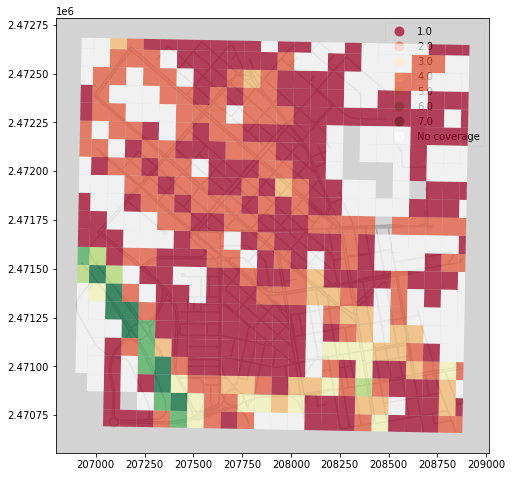

In [115]:
# visualise the number of years in which each grid cell is covered

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot roads on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)

# plot lines on Axis ax
df_grid_nyears.plot(ax=ax, 
                           column='nyears', 
                           categorical=True, 
                           cmap='RdYlGn',
                           legend=True, alpha=0.7, zorder=10,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey'})





## 3.7 Number of months covered

- Street-based: the number of months (i.e. January, February, March, ...) in which the street has SVI available
- Grid-based: the number of months in which the cell has SVI available

### Street-based

<AxesSubplot:>

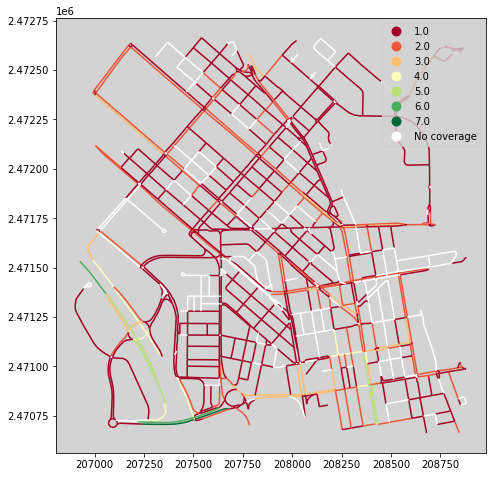

In [116]:
# visualise number of months in which each road is covered

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot lines on Axis ax
df_lines_nym.plot(ax=ax, 
                           column='nmonths', 
                           categorical=True, 
                           cmap='RdYlGn',
                           legend=True,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey'})



### Grid-based

In [117]:
# join nmonths to grid by cell index
df_grid_nmonths = df_pop_proj.copy()
df_grid_nmonths = df_grid_nmonths.join(nmonths_by_grid)
df_grid_nmonths.head()

,geometry,pop_count,nmonths
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,2.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,2.0


In [118]:
df_grid_nmonths.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 514 entries, 28805 to 31703
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   514 non-null    geometry
 1   pop_count  514 non-null    float64 
 2   nmonths    380 non-null    float64 
dtypes: float64(2), geometry(1)
memory usage: 32.2 KB


<AxesSubplot:>

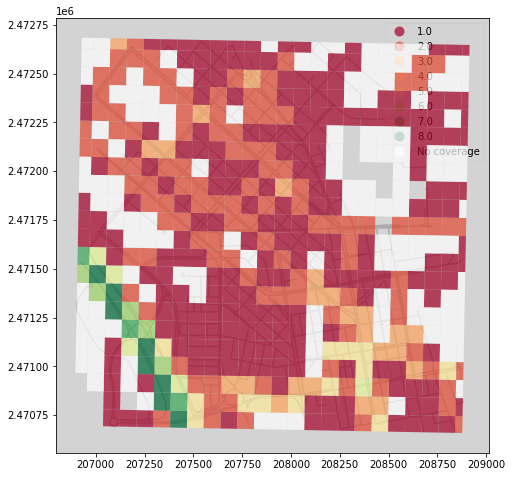

In [119]:
# visualise the number of months in which each grid cell is covered

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot roads on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)

# plot lines on Axis ax
df_grid_nmonths.plot(ax=ax, 
                           column='nmonths', 
                           categorical=True, 
                           cmap='RdYlGn', zorder=10,
                           legend=True, alpha=0.7,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey'})





## 3.8 Time elapsed between coverage

- Street-based: the average amount of time elapsed between coverage occurrences, for each street
- Grid-based: the average amount of time elapsed between coverage occurrences, for each cell

### Street-based

In [125]:
# select those images taken on the same day as one group, and calculate how many groups there are on each road
# a simple and fast (though not the most accurate) way to do so is by calculating their ages in days and then obtain the number of unique ages
nday_grp = snapped_dt.groupby('index')['age_d'].nunique()

In [126]:
df_lines_tl = df_lines_nym.copy()
df_lines_tl['n_sameday'] = nday_grp  # number of 'same day' groups on each road, i.e. the number of times the road has been covered for
df_lines_tl.head()

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,coverage,category,photos_count,cal_length,avg_sample_dist,age_newest,age_oldest,nyears,nmonths,n_sameday
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,100.00,100%,124.0,433.212488,3.49,2.0,5.0,2.0,2.0,3.0
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,81.89,>75%,46.0,453.958612,9.87,2.0,5.0,2.0,2.0,3.0
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,NaN,0%,NaN,264.125775,NaN,NaN,NaN,NaN,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,100.00,100%,18.0,235.191714,13.07,2.0,2.0,1.0,1.0,1.0
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,100.00,100%,7.0,61.488773,8.78,5.0,5.0,1.0,1.0,1.0


In [128]:
df_lines_tl['n_sameday'].value_counts()  # for this dataset, most roads have been covered only once or twice

1.0     514
2.0     170
3.0      71
4.0      13
6.0       7
7.0       3
5.0       2
10.0      1
12.0      1
8.0       1
Name: n_sameday, dtype: int64

In [129]:
# find the maximum image age (in days) on each road
max_age_d = snapped_dt.groupby('index')['age_d'].max()
max_age_d

index
0       1851.0
1       1851.0
3        843.0
4       1851.0
5       1851.0
         ...  
1035    1850.0
1036    1850.0
1037    1850.0
1038    1849.0
1040    1850.0
Name: age_d, Length: 783, dtype: float64

In [130]:
# find the minimum image age (in days) on each road
min_age_d = snapped_dt.groupby('index')['age_d'].min()
min_age_d

index
0        843.0
1        843.0
3        843.0
4       1851.0
5       1850.0
         ...  
1035    1850.0
1036    1850.0
1037    1850.0
1038    1849.0
1040    1850.0
Name: age_d, Length: 783, dtype: float64

In [131]:
df_lines_tl['max_age_d'] = max_age_d
df_lines_tl['min_age_d'] = min_age_d
df_lines_tl.head()

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,photos_count,cal_length,avg_sample_dist,age_newest,age_oldest,nyears,nmonths,n_sameday,max_age_d,min_age_d
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,124.0,433.212488,3.49,2.0,5.0,2.0,2.0,3.0,1851.0,843.0
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,46.0,453.958612,9.87,2.0,5.0,2.0,2.0,3.0,1851.0,843.0
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,NaN,264.125775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,18.0,235.191714,13.07,2.0,2.0,1.0,1.0,1.0,843.0,843.0
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,7.0,61.488773,8.78,5.0,5.0,1.0,1.0,1.0,1851.0,1851.0


In [132]:
# calculate the total number of days elapsed between the first and the last coverage trips on each road
df_lines_tl['timelapse_d'] = df_lines_tl['max_age_d'] - df_lines_tl['min_age_d']
df_lines_tl.head()

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,cal_length,avg_sample_dist,age_newest,age_oldest,nyears,nmonths,n_sameday,max_age_d,min_age_d,timelapse_d
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,433.212488,3.49,2.0,5.0,2.0,2.0,3.0,1851.0,843.0,1008.0
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,453.958612,9.87,2.0,5.0,2.0,2.0,3.0,1851.0,843.0,1008.0
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,264.125775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,235.191714,13.07,2.0,2.0,1.0,1.0,1.0,843.0,843.0,0.0
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,61.488773,8.78,5.0,5.0,1.0,1.0,1.0,1851.0,1851.0,0.0


In [133]:
# calculate the average number of days elapsed between coverage trips for each road
def calculate_timelapse_d(row):
    if row['timelapse_d'] == 0:
        return 0
    else:
        avg_tl_d = round(row['timelapse_d']/(row['n_sameday']-1), 0)
        return avg_tl_d

df_lines_tl['avg_tl_d'] = df_lines_tl.apply(lambda row: calculate_timelapse_d(row), axis=1)
df_lines_tl.head()


,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,avg_sample_dist,age_newest,age_oldest,nyears,nmonths,n_sameday,max_age_d,min_age_d,timelapse_d,avg_tl_d
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,3.49,2.0,5.0,2.0,2.0,3.0,1851.0,843.0,1008.0,504.0
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,9.87,2.0,5.0,2.0,2.0,3.0,1851.0,843.0,1008.0,504.0
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,13.07,2.0,2.0,1.0,1.0,1.0,843.0,843.0,0.0,0.0
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,8.78,5.0,5.0,1.0,1.0,1.0,1851.0,1851.0,0.0,0.0


In [134]:
# categorise the roads into only covered once (all photos were taken on the same day), no coverage, or covered multiple times

def all_in_same_day(timelapse_d):
    if timelapse_d == 0:
        return 'Only covered once'
    elif timelapse_d == np.NaN:
        return 'No coverage'
    else:
        return 'Covered multiple times'

df_lines_tl['all_in_same_day'] = df_lines_tl['timelapse_d'].apply(lambda x: all_in_same_day(x))
df_lines_tl.head()

,index,u,v,key,osmid,bridge,oneway,lanes,ref,name,...,age_newest,age_oldest,nyears,nmonths,n_sameday,max_age_d,min_age_d,timelapse_d,avg_tl_d,all_in_same_day
0,0,274243013,274243016,0,"[909703708, 30151798]",viaduct,True,3,5,西九龍走廊 West Kowloon Corridor,...,2.0,5.0,2.0,2.0,3.0,1851.0,843.0,1008.0,504.0,Covered multiple times
1,1,274243013,5049131572,0,151355641,yes,True,2,NaN,NaN,...,2.0,5.0,2.0,2.0,3.0,1851.0,843.0,1008.0,504.0,Covered multiple times
2,2,274243016,6984393965,0,30150187,viaduct,True,2,5,西九龍走廊 West Kowloon Corridor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Covered multiple times
3,3,274243016,4773779436,0,"[30150256, 909700420, 102368462]",yes,True,2,NaN,"[西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...",...,2.0,2.0,1.0,1.0,1.0,843.0,843.0,0.0,0.0,Only covered once
4,4,275909450,991295018,0,85988268,NaN,True,2,NaN,桂林街 Kweilin Street,...,5.0,5.0,1.0,1.0,1.0,1851.0,1851.0,0.0,0.0,Only covered once


<AxesSubplot:>

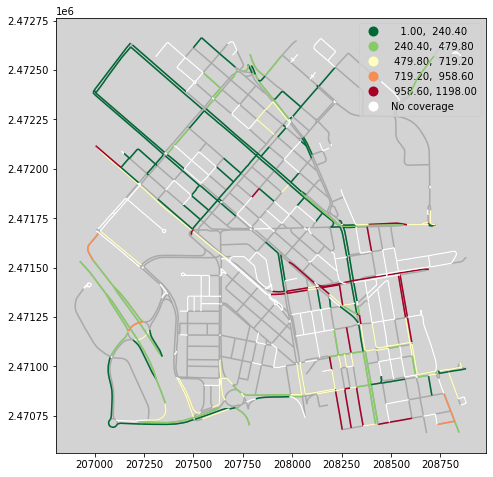

In [135]:
# visualise average time elapsed (in days) between coverage on each road

fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot roads on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5) # darkgrey - only covered in one day

# plot lines on Axis ax
df_lines_tl[df_lines_tl['timelapse_d'] != 0].plot(ax=ax, 
                           column='avg_tl_d', 
                           scheme='equal_interval', 
                           cmap='RdYlGn_r',
                           k=5, zorder=10,
                           legend=True,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey'})



### Grid-based

In [136]:
# select those images taken on the same day as one group, and calculate how many groups there are in each grid cell
ndays_grp_grid = df_grid_dt_idx.groupby('index')['age_d'].nunique()
ndays_grp_grid = ndays_grp_grid.rename('n_sameday')
ndays_grp_grid


index
28459    4
28460    3
28461    1
28462    1
28463    2
        ..
32072    1
32073    1
32074    1
32075    2
32076    3
Name: n_sameday, Length: 380, dtype: int64

In [137]:
# find the maximum image age (in days) in each grid cell
max_age_d = df_grid_dt_idx.groupby('index')['age_d'].max()
max_age_d = max_age_d.rename('max_age_d')
max_age_d

index
28459    2041.0
28460    2041.0
28461    1851.0
28462    1851.0
28463    1851.0
          ...  
32072     803.0
32073    1850.0
32074    1850.0
32075    1850.0
32076    1850.0
Name: max_age_d, Length: 380, dtype: float64

In [138]:
# find the minimum image age (in days) in each grid cell
min_age_d = df_grid_dt_idx.groupby('index')['age_d'].min()
min_age_d = min_age_d.rename('min_age_d')
min_age_d

index
28459     185.0
28460    1850.0
28461    1851.0
28462    1851.0
28463    1849.0
          ...  
32072     803.0
32073    1850.0
32074    1850.0
32075    1118.0
32076    1118.0
Name: min_age_d, Length: 380, dtype: float64

In [139]:
# calculate the total number of days elapsed between the first and the last coverage trips in each cell
timelapse_d = max_age_d - min_age_d
timelapse_d = timelapse_d.rename('timelapse_d')
timelapse_d

index
28459    1856.0
28460     191.0
28461       0.0
28462       0.0
28463       2.0
          ...  
32072       0.0
32073       0.0
32074       0.0
32075     732.0
32076     732.0
Name: timelapse_d, Length: 380, dtype: float64

In [140]:
# join n_sameday and timelapsed_d to grid by cell index
df_grid_tl = df_pop_proj.copy()
df_grid_tl = df_grid_tl.join(ndays_grp_grid)
df_grid_tl = df_grid_tl.join(timelapse_d)
df_grid_tl.head()

,geometry,pop_count,n_sameday,timelapse_d
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN,NaN
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,3.0,191.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0,0.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,3.0,191.0


In [141]:
# calculate the average number of days elapsed between coverage trips for each cell
df_grid_tl['avg_tl_d'] = df_grid_tl.apply(lambda row: calculate_timelapse_d(row), axis=1)
df_grid_tl.head()


,geometry,pop_count,n_sameday,timelapse_d,avg_tl_d
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN,NaN,NaN
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,3.0,191.0,96.0
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN,NaN,NaN
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0,0.0,0.0
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,3.0,191.0,96.0


In [142]:
# categorise the cells into only covered once (all photos were taken on the same day), no coverage, or covered multiple times
df_grid_tl['all_in_same_day'] = df_grid_tl['timelapse_d'].apply(lambda x: all_in_same_day(x))
df_grid_tl.head()

,geometry,pop_count,n_sameday,timelapse_d,avg_tl_d,all_in_same_day
28805,"POLYGON ((207500.811 2472525.021, 207499.071 2...",772.237122,NaN,NaN,NaN,Covered multiple times
28801,"POLYGON ((207157.250 2472531.501, 207155.508 2...",736.694336,3.0,191.0,96.0,Covered multiple times
28799,"POLYGON ((206985.469 2472534.743, 206983.726 2...",321.802856,NaN,NaN,NaN,Covered multiple times
28806,"POLYGON ((207586.701 2472523.403, 207584.962 2...",741.851318,1.0,0.0,0.0,Only covered once
28804,"POLYGON ((207414.921 2472526.641, 207413.180 2...",1036.713745,3.0,191.0,96.0,Covered multiple times


<AxesSubplot:>

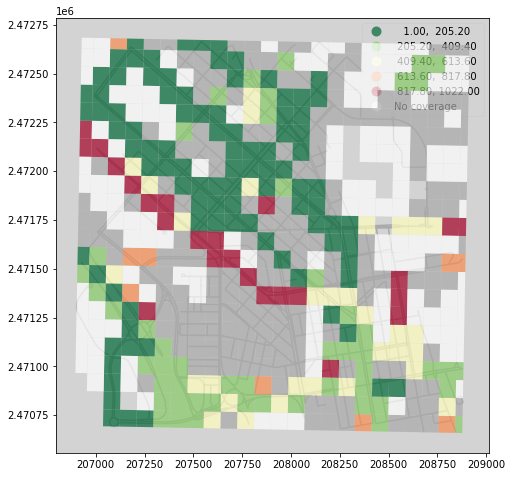

In [143]:
# visualise average time elapsed (in days) between coverage in each cell

# plot place area on Axis ax
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5) 

df_grid_tl[df_grid_tl['timelapse_d'] == 0].plot(ax=ax, color='darkgrey', alpha=0.7, zorder=8) # darkgrey - only covered in one day

# plot lines on Axis ax
df_grid_tl[df_grid_tl['timelapse_d'] != 0].plot(ax=ax, 
                           column='avg_tl_d', 
                           scheme='equal_interval', 
                           cmap='RdYlGn_r',
                           k=5, alpha=0.7, zorder=10,
                           legend=True,
                       missing_kwds={'color': "white",
                                     'label': "No coverage"}, 
                       legend_kwds={'facecolor':'lightgrey'})



## 3.9 Image blurriness

Automatically detects how blurry each image is.

In [144]:
# the GeoDataFrame of the sample of images downloaded
sample_df

,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,geometry,image_filename
9,278160913996402,EhOvlAFXdZ_6Vhua_sP_3g,197.79,1491733818000,perspective,1.619719,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207074.974 2470729.352),An-4IL8piN4qhxAaxKzJT2846DxFMhTJNAPX25m-ZqIB1n...
19,314923413574419,EhOvlAFXdZ_6Vhua_sP_3g,197.84,1491733817000,perspective,336.951764,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207069.530 2470727.169),An_2cZC5x2g6SboLHzQlKuzq7b4e7hlbnbTEovNU_EWLNB...
29,4197513526965995,EhOvlAFXdZ_6Vhua_sP_3g,197.99,1491733815000,perspective,269.286951,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207066.920 2470716.164),An91BJHALllDYY1UJ1bl6b_2RO_bxNqIN46a9PkO_qlHHJ...
39,956015131892843,aPHUgw-HBTdYEqMJ9fD8WQ,0.00,1491733821000,perspective,149.385483,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207109.386 2470724.987),An9Ed6QodHlaDwz6wai1mEEfdVDouEGeGlFe23kLWd_cem...
49,369543207809790,ubuSVGpvxy3cn5MxQxSiqw,196.36,1491734193000,perspective,232.008840,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207078.545 2470697.840),An9mieR62IMK5c6-hJ1nBSttHtrODAvouKesgH0TE3r_e2...
...,...,...,...,...,...,...,...,...,...,...,...
23079,467283994557335,ilC9-rItUMOnlUpx-Jzsuw,0.00,1491710236000,perspective,197.132328,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207521.403 2472657.504),An9yQOVdw30jIBGYCMlOdIBCrl9D1PoJ6mtstWgAKHldMD...
23089,499620911162963,SyWlDU8NtYUGXqDqvf1bmA,29.06,1491806601000,perspective,19.174803,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207545.838 2472661.354),An_gtWGeW6NTykC1zbqVOvezGh3uQw7QQJMkZD_MmLT_nw...
23099,141220167988209,Q_uQXNrdiVeoMB1zf0HZDA,0.00,1491806601000,perspective,108.292153,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207552.229 2472654.712),An9ypBvYNtPJs-TeNJRViuTHvJKy8kP5G3sAH2SUAKaejL...
23109,771607883717414,vG-hFxmHJoshbQztkCNSxA,0.00,1491791291000,perspective,222.462083,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (208330.280 2472640.003),An-IcqmToTbnkjuYm1NiSfl9-QjW0MhHUw7M9BKXUjC4gH...


In [145]:
# calculate the focus measure for each image and determine whether it is blurry using a threshold
# usually, a higher focus measure implies that the image is less blurry
# reference: https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

import cv2

def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

threshold = 150
fm_list = []
blurry_list = []

for name in sample_df['image_filename'].tolist():
    image_path = os.path.join(images_sample_folder, name)
    # load the image, convert it to grayscale, and compute the focus measure
    # of the image using the Variance of Laplacian method
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray)
    fm_list.append(fm)
    
    text = 'Not blurry'
    
    # if the focus measure is less than the defined threshold, 
    # then the image should be considered "blurry"
    if fm < threshold:
        text = 'Blurry'
    
    blurry_list.append(text)
        
    # show the image
    """
    cv2.putText(image, f'{text}: {fm:.2f}', (750, 1020),
               cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    cv2.imshow("Image", image)
    cv2.waitKey(0)
    """

sample_df['focus_measure'] = fm_list
sample_df['blurriness'] = blurry_list
sample_df


,id,sequence,altitude,captured_at,camera_type,compass_angle,width,height,thumb_2048_url,geometry,image_filename,focus_measure,blurriness
9,278160913996402,EhOvlAFXdZ_6Vhua_sP_3g,197.79,1491733818000,perspective,1.619719,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207074.974 2470729.352),An-4IL8piN4qhxAaxKzJT2846DxFMhTJNAPX25m-ZqIB1n...,189.045793,Not blurry
19,314923413574419,EhOvlAFXdZ_6Vhua_sP_3g,197.84,1491733817000,perspective,336.951764,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207069.530 2470727.169),An_2cZC5x2g6SboLHzQlKuzq7b4e7hlbnbTEovNU_EWLNB...,167.812512,Not blurry
29,4197513526965995,EhOvlAFXdZ_6Vhua_sP_3g,197.99,1491733815000,perspective,269.286951,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207066.920 2470716.164),An91BJHALllDYY1UJ1bl6b_2RO_bxNqIN46a9PkO_qlHHJ...,299.075213,Not blurry
39,956015131892843,aPHUgw-HBTdYEqMJ9fD8WQ,0.00,1491733821000,perspective,149.385483,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207109.386 2470724.987),An9Ed6QodHlaDwz6wai1mEEfdVDouEGeGlFe23kLWd_cem...,100.792698,Blurry
49,369543207809790,ubuSVGpvxy3cn5MxQxSiqw,196.36,1491734193000,perspective,232.008840,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207078.545 2470697.840),An9mieR62IMK5c6-hJ1nBSttHtrODAvouKesgH0TE3r_e2...,218.247470,Not blurry
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23079,467283994557335,ilC9-rItUMOnlUpx-Jzsuw,0.00,1491710236000,perspective,197.132328,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207521.403 2472657.504),An9yQOVdw30jIBGYCMlOdIBCrl9D1PoJ6mtstWgAKHldMD...,328.928619,Not blurry
23089,499620911162963,SyWlDU8NtYUGXqDqvf1bmA,29.06,1491806601000,perspective,19.174803,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207545.838 2472661.354),An_gtWGeW6NTykC1zbqVOvezGh3uQw7QQJMkZD_MmLT_nw...,354.900215,Not blurry
23099,141220167988209,Q_uQXNrdiVeoMB1zf0HZDA,0.00,1491806601000,perspective,108.292153,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (207552.229 2472654.712),An9ypBvYNtPJs-TeNJRViuTHvJKy8kP5G3sAH2SUAKaejL...,322.985050,Not blurry
23109,771607883717414,vG-hFxmHJoshbQztkCNSxA,0.00,1491791291000,perspective,222.462083,1920,1080,https://scontent.fsin10-1.fna.fbcdn.net/m1/v/t...,POINT (208330.280 2472640.003),An-IcqmToTbnkjuYm1NiSfl9-QjW0MhHUw7M9BKXUjC4gH...,584.237519,Not blurry


<AxesSubplot:xlabel='focus_measure', ylabel='Count'>

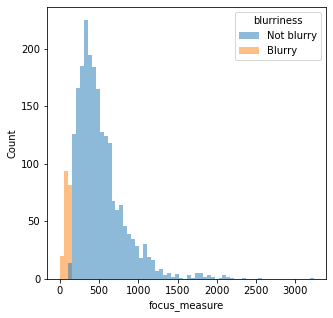

In [146]:
# plot histogram to show the distribution of focus measure among all the downloaded images
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=sample_df, x='focus_measure', hue='blurriness', stat='count', edgecolor=None)


In [147]:
# calculate the number and percentage of blurry/ non-blurry images
nblur = len(sample_df[sample_df['blurriness'] == 'Blurry'])
pblur = round(nblur/len(sample_df)*100, 2)
nclear = len(sample_df[sample_df['blurriness'] == 'Not blurry'])
pclear = 100-pblur
print(f'Number of blurry images: {nblur} ({pblur}%)')
print(f'Number of non-blurry images: {nclear} ({pclear}%)')

Number of blurry images: 196 (8.48%)
Number of non-blurry images: 2116 (91.52%)


<AxesSubplot:>

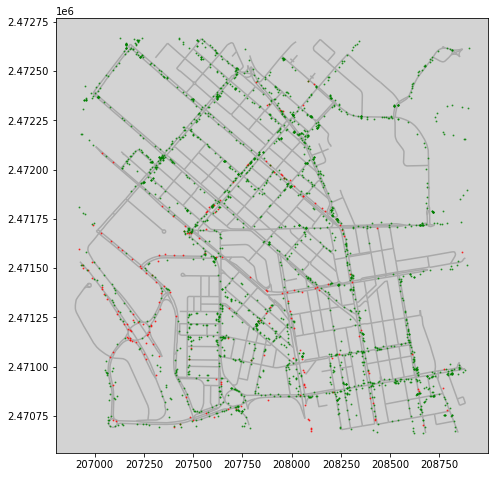

In [150]:
# plot the distribution of blurry and non-blurry images on map

# create Matplotlib figure
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('lightgrey')

# plot place area on Axis ax
df_lines_proj.plot(ax=ax, color='darkgrey', zorder=5)

# plot all images on Axis ax
#df_points_proj.plot(ax=ax, marker='o', color='green', markersize=2, alpha=0.5, zorder=10)

# plot downloaded images on Axis ax
sample_df[sample_df['blurriness'] == 'Blurry'].plot(ax=ax, marker='o', color='red', markersize=0.8, alpha=0.7, zorder=10)
sample_df[sample_df['blurriness'] == 'Not blurry'].plot(ax=ax, marker='o', color='green', markersize=0.8, alpha=0.7, zorder=10)


In [151]:
# the filename of the image with the highest focus measure 
sample_df[sample_df['focus_measure'] == sample_df['focus_measure'].max()]['image_filename'].tolist()[0]


'An82bbR78dffSh5YRbaqg2sGTMbsyaG2DinKJ8tA-sJjDbOBre06tumPxQnXChscD2DixrZ7FMX1-pw-bPIBfbBkE0sCLntJ4kysJHiNowki8L_wF8V9YsvSdVhB-dtTKu5u4stqy3LqxPWtlfELZQ?stp=s2048x1536&ccb=10-5&oh=00_AT_9H5lq1kqc3OkEOvOGjieFSp58FdGk79yQtAQ_g7Epsg&oe=62193DFA&_nc_sid=122ab1'

In [152]:
# the highest focus measure among all sampled images
sample_df['focus_measure'].max()

3231.0391319622827

In [153]:
# the filename of the image with the lowest focus measure 
sample_df[sample_df['focus_measure'] == sample_df['focus_measure'].min()]['image_filename'].tolist()[0]


'An990N3xxGojC1ax3SZeyc-wbAoKbSJYImRuogAQFmRBiX9AnvOqj7Faeot4tYoMYiR4F-ThMvM8eMlLHfaYfLEClZ4LJPawc674wX-fLw5FOl7CER4TQi51uLhe7Llcgu49bJOfNb8Tuj3pH1ywRg?stp=s2048x1152&ccb=10-5&oh=00_AT-y7F4tNvacez5pYZqxPhRu6i5MrA7Tpg5oVMzIxgR7kw&oe=6219BD34&_nc_sid=122ab1'

In [154]:
# the lowest focus measure among all sampled images
sample_df['focus_measure'].min()

2.3972680191854034